[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/cseeg/DiSCoVeR-SuperCon-NOMAD-SMACT/blob/hasan_branch/Post%20processing/DiSCoVeR_SuperCon_NOMAD_SMACT.ipynb)

##Setup

In [1]:
from os import path
try:
  import google.colab
  IN_COLAB = True
  base_dir = "/content/drive/MyDrive/"
except:
  IN_COLAB = False
  base_dir = path.join("data", "external")

In [18]:
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
# !chmod +x mini.sh
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py38" --user

In [2]:
if IN_COLAB:
  %pip install crabnet
  %pip install pymatgen
  # %pip install mp-api
  %pip install ax-platform

##Materials Project API Key
Get your [Materials Project API key](https://next-gen.materialsproject.org/api) from a file that you store in your Google Drive (see below) or current directory (.).

The file named mp-api-key.json placed directly in your MyDrive folder or in your current directory would look like the following:

```json
{
    "API_KEY": "YOUR_API_KEY"
}
```

In [3]:
import json
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  apikey_fpath = "/content/drive/MyDrive/mp-api-key.json"
  try:
    # https://stackoverflow.com/a/68442279/13697228
    with open(apikey_fpath, 'r') as f:
        json_data = json.load(f)
        api_key = json_data["API_KEY"]
  except Exception as e:
    print(e)
    api_key = "" #@param {type:"string"}
    if api_key == "":
      print(f"Couldn't load API key from {apikey_fpath}, and user-input API key is also empty.")
    print(f"defaulting to user-input API key {api_key}")
    pass
else:
  api_key = None
  print("make sure that you have run `pmg config --add PMG_MAPI_KEY <USER_API_KEY>`")

make sure that you have run `pmg config --add PMG_MAPI_KEY <USER_API_KEY>`


In [4]:
!pip install gpytorch==1.8.1
!pip install ax-platform

In [5]:
# from mp_api.client import MPRester
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from crabnet.crabnet_ import CrabNet

# for hyperparameter optimization

import pprint
from os.path import join
from pathlib import Path
import numpy as np

import plotly.graph_objects as go

import gc
import torch

from ax.service.managed_loop import optimize
from ax.storage.json_store.save import save_experiment
from ax.plot.trace import optimization_trace_single_method
from sklearn.metrics import mean_absolute_error

##Download data from materials project

In [ ]:
# with MPRester(api_key) as mpr:
#     docs = mpr.summary.search(fields=["formula_pretty",
#                                       "energy_above_hull",
#                                       "theoretical"])

##Getting training and validation datasets for e_above_hull

In [6]:
# formula = []
# target = []

# for s in tqdm(docs):
#     f = s.formula_pretty
#     e = s.energy_above_hull
#     formula.append(f)
#     target.append(e)
  
# df_e = pd.DataFrame(list(zip(formula, target)), columns =['formula', 'target'])
# df_e = df_e[df_e['target'].notna()]

# train_df_e, val_df_e = train_test_split(df_e, test_size=0.20, random_state=42)

train_data_fpath = "C:/Users/Hasan Sayeed/Documents/hasan/DISCOVER/e_above_hull.csv"     # "/content/drive/MyDrive/e_above_hull.csv"

with open(train_data_fpath, 'r') as f:
    df_e = pd.read_csv(train_data_fpath, sep=",")

In [7]:
df_e = df_e[df_e['formula'].apply(lambda x: isinstance(x, (str)))]

In [8]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(df_e['formula'], df_e['target'], test_size=0.20, random_state=42)
# train_df_e, val_df_e = train_test_split(df_e, test_size=0.20, random_state=42)

In [9]:
df_train_e = pd.DataFrame({"formula": X_train_e, "target": y_train_e})
df_test_e = pd.DataFrame({"formula": X_test_e, "target": y_test_e})

## Optimizing crabnet with AX for e_above_hull prediction

In [10]:
# def correct_parameterization(parameterization):
#     pprint.pprint(parameterization)

#     parameterization["out_hidden"] = [
#         parameterization.get("out_hidden4") * 8,
#         parameterization.get("out_hidden4") * 4,
#         parameterization.get("out_hidden4") * 2,
#         parameterization.get("out_hidden4"),
#     ]
#     parameterization.pop("out_hidden4")

#     parameterization["betas"] = (
#         parameterization.get("betas1"),
#         parameterization.get("betas2"),
#     )
#     parameterization.pop("betas1")
#     parameterization.pop("betas2")

#     d_model = parameterization["d_model"]

#     # make heads even (unless it's 1) (because d_model must be even)
#     heads = parameterization["heads"]
#     if np.mod(heads, 2) != 0:
#         heads = heads + 1
#     parameterization["heads"] = heads

#     # NOTE: d_model must be divisible by heads
#     d_model = parameterization["heads"] * round(d_model / parameterization["heads"])

#     parameterization["d_model"] = d_model

#     parameterization["pos_scaler_log"] = (
#         1 - parameterization["emb_scaler"] - parameterization["pos_scaler"]
#     )

#     parameterization["epochs"] = parameterization["epochs_step"] * 4

#     return parameterization

In [11]:
def crabnet_evaluation(parameterization):
        """Compute the RMSE of a CrabNet model."""
        # parameterization = correct_parameterization(parameterization)
        model= CrabNet(**parameterization, force_cpu=False, epochs=300)
        model.fit(df_train_e)
        y_predicted= model.predict(df_test_e)

        mae = mean_absolute_error(df_test_e['target'].to_list(), y_predicted)
        
        # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
        del model
        gc.collect()
        torch.cuda.empty_cache()


        return {"mae":mae}

[INFO 09-20 10:22:08] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-20 10:22:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter fudge. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-20 10:22:08] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter N. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-20 10:22:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter emb_scaler. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict


Model architecture: out_dims, d_model, N, heads
3, 512, 9, 4
Running on compute device: cuda:1
Model size: 23041810 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 208144.40formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 229036.89formulae/s]


loading data with up to 9 elements in the formula
stepping every 2928 training passes, cycling lr every 8 epochs
checkin at 16 epochs to match lr scheduler
300 epochs not divisible by 16 (2*epochs_step), updating epochs to 304 for learning


c:\Users\Hasan Sayeed\anaconda3\lib\site-packages\crabnet\utils\utils.py:712: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  adam_step.add_(group["weight_decay"], p.data)


Epoch: 0/304 --- train mae: 0.208 val mae: 0.205


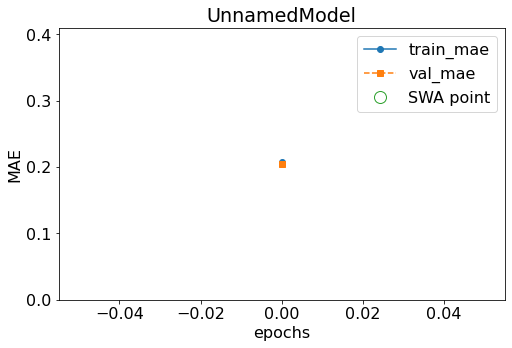

Epoch: 15/304 --- train mae: 0.2 val mae: 0.2


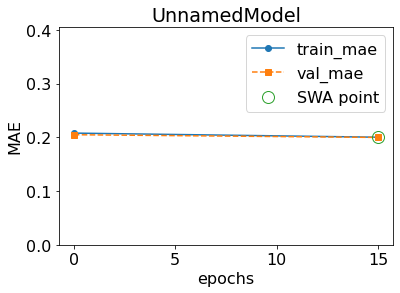

Epoch: 31/304 --- train mae: 0.19 val mae: 0.19


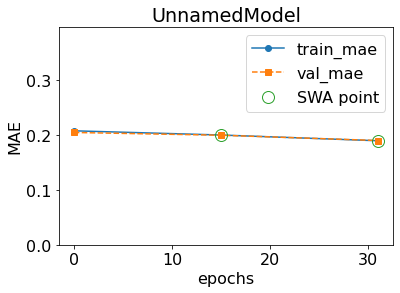

Epoch: 47/304 --- train mae: 0.177 val mae: 0.179


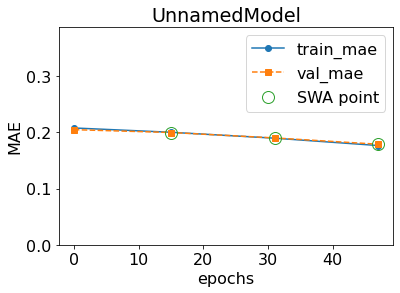

Epoch: 63/304 --- train mae: 0.169 val mae: 0.173


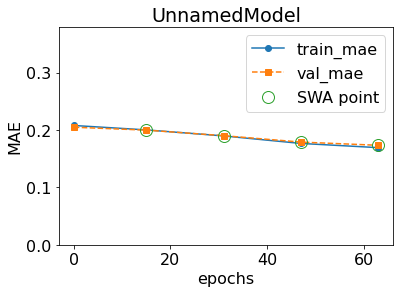

Epoch: 79/304 --- train mae: 0.163 val mae: 0.169


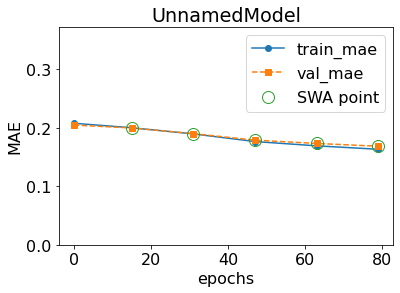

Epoch: 95/304 --- train mae: 0.158 val mae: 0.164


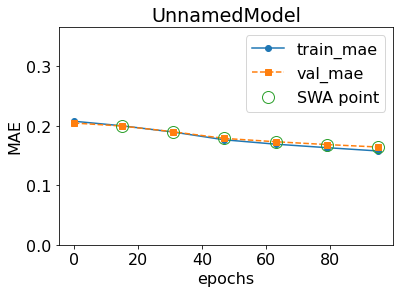

Epoch: 111/304 --- train mae: 0.154 val mae: 0.162


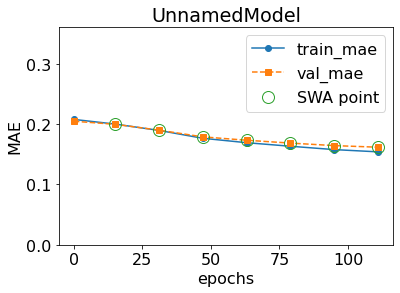

Epoch: 127/304 --- train mae: 0.15 val mae: 0.159


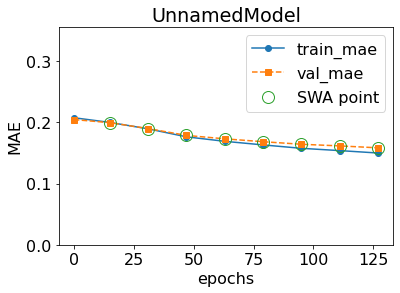

Epoch: 143/304 --- train mae: 0.147 val mae: 0.157


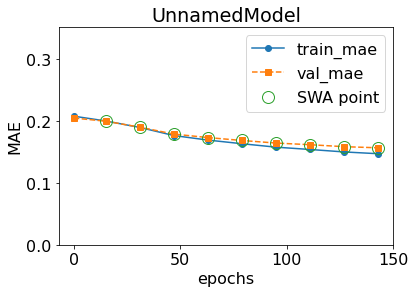

Epoch: 159/304 --- train mae: 0.143 val mae: 0.154


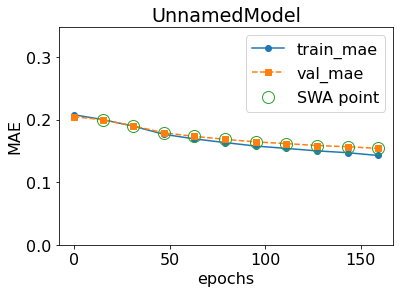

Epoch 175 failed to improve.
Discarded: 1/3 weight updates
Epoch: 175/304 --- train mae: 0.146 val mae: 0.158


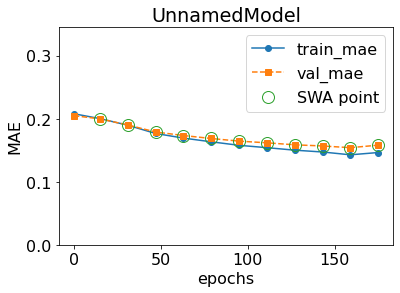

Epoch 191 failed to improve.
Discarded: 2/3 weight updates
Epoch: 191/304 --- train mae: 0.145 val mae: 0.157


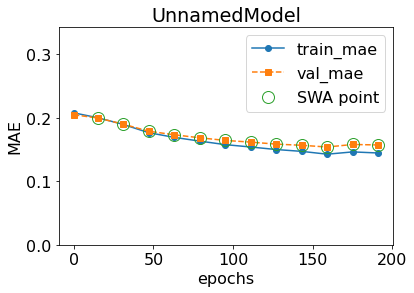

Epoch: 207/304 --- train mae: 0.142 val mae: 0.155


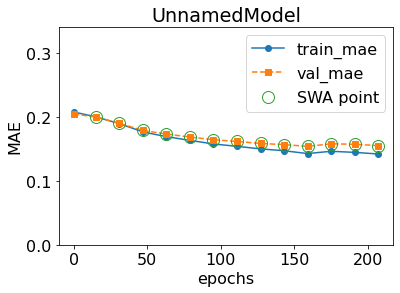

Epoch: 223/304 --- train mae: 0.14 val mae: 0.153


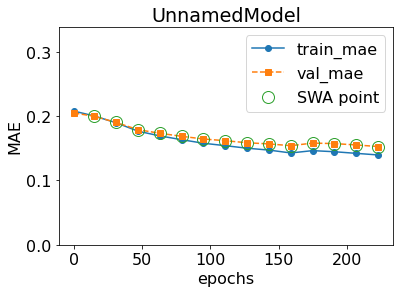

Epoch: 239/304 --- train mae: 0.138 val mae: 0.153


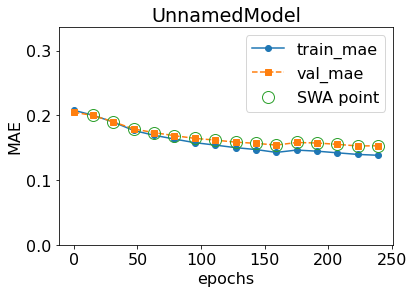

Epoch: 255/304 --- train mae: 0.138 val mae: 0.153


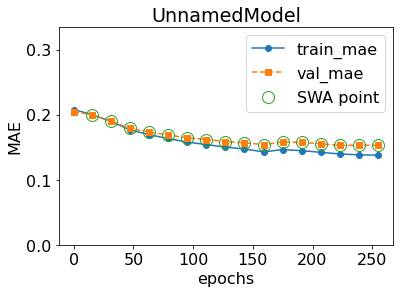

Epoch: 271/304 --- train mae: 0.136 val mae: 0.152


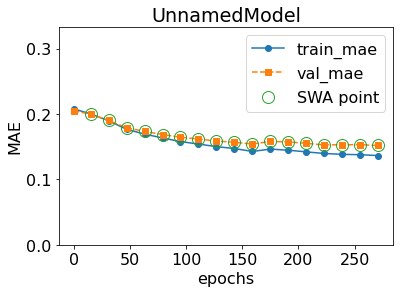

Epoch: 287/304 --- train mae: 0.136 val mae: 0.152


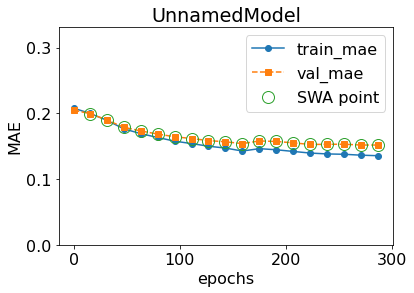

Epoch: 303/304 --- train mae: 0.134 val mae: 0.151


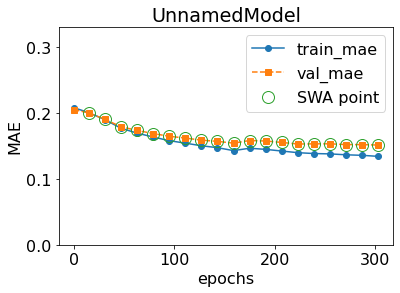

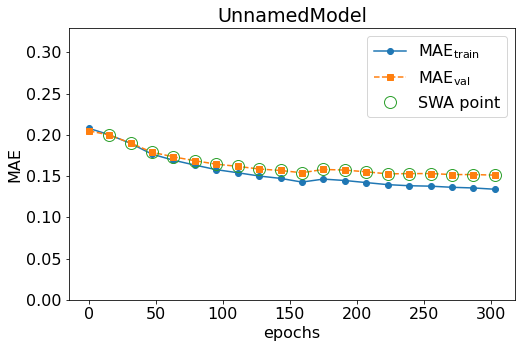

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 234453.20formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-20 19:23:39] ax.service.managed_loop: Running optimization trial 2...



Model architecture: out_dims, d_model, N, heads
3, 512, 8, 4
Running on compute device: cuda:1
Model size: 27576926 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 211458.01formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 82 (2**6.358)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 227911.52formulae/s]


loading data with up to 9 elements in the formula
stepping every 20556 training passes, cycling lr every 18 epochs
checkin at 36 epochs to match lr scheduler
300 epochs not divisible by 36 (2*epochs_step), updating epochs to 324 for learning
Epoch: 0/324 --- train mae: 0.224 val mae: 0.216


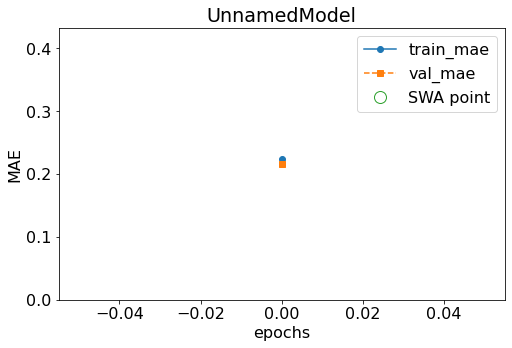

Epoch: 35/324 --- train mae: 0.226 val mae: 0.218


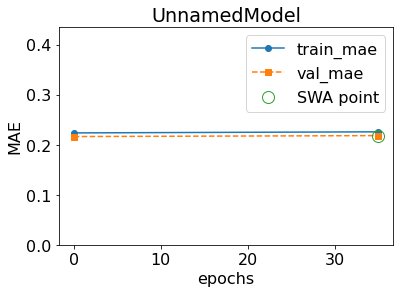

Epoch: 71/324 --- train mae: 0.226 val mae: 0.218


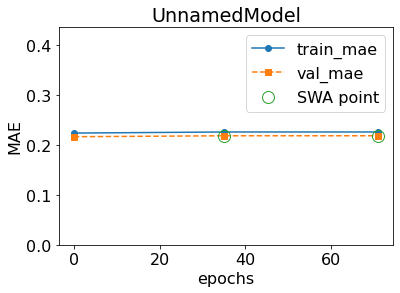

Epoch: 107/324 --- train mae: 0.226 val mae: 0.218


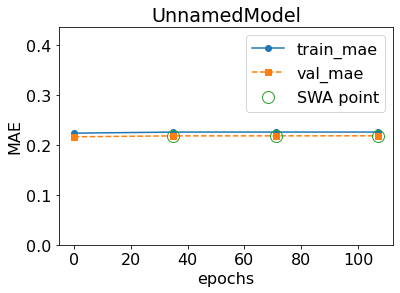

Epoch: 143/324 --- train mae: 0.226 val mae: 0.218


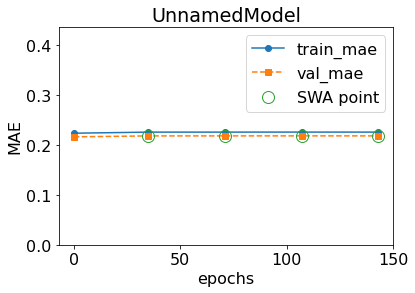

Epoch: 179/324 --- train mae: 0.226 val mae: 0.218


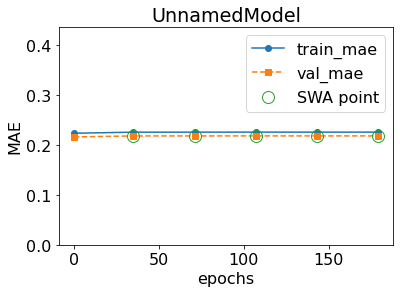

Epoch: 215/324 --- train mae: 0.226 val mae: 0.218


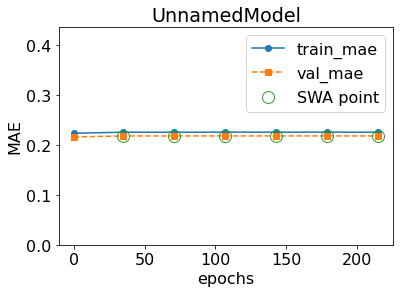

Epoch: 251/324 --- train mae: 0.226 val mae: 0.218


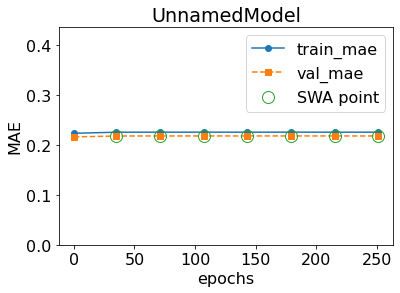

Epoch: 287/324 --- train mae: 0.226 val mae: 0.218


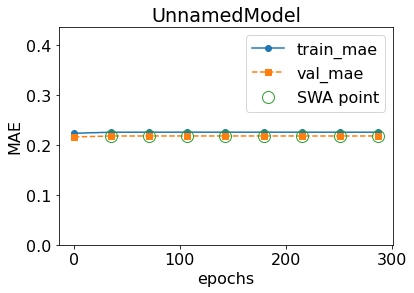

Epoch: 323/324 --- train mae: 0.226 val mae: 0.218


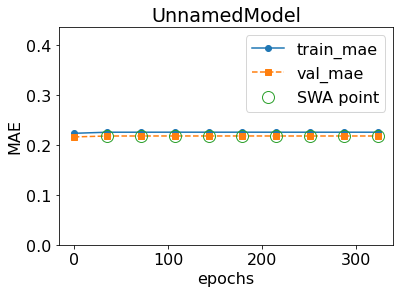

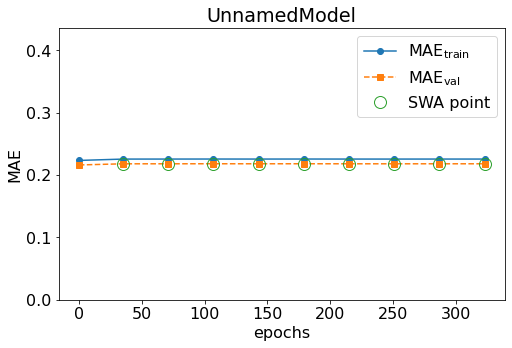

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 236661.94formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-21 15:43:00] ax.service.managed_loop: Running optimization trial 3...



Model architecture: out_dims, d_model, N, heads
3, 512, 4, 4
Running on compute device: cuda:1
Model size: 22818890 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 207717.85formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 99 (2**6.629)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 234807.69formulae/s]


loading data with up to 9 elements in the formula
stepping every 5676 training passes, cycling lr every 6 epochs
checkin at 12 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.174 val mae: 0.172


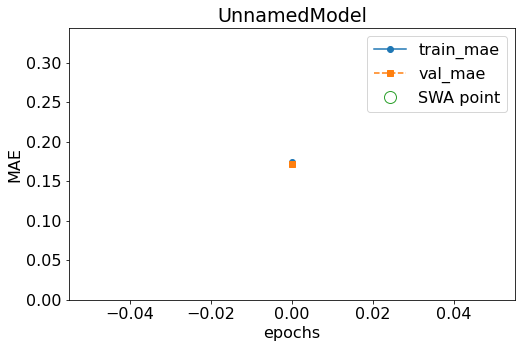

Epoch: 11/300 --- train mae: 0.13 val mae: 0.131


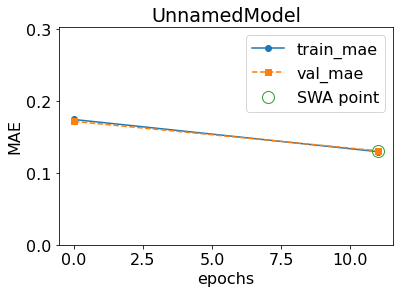

Epoch: 23/300 --- train mae: 0.115 val mae: 0.122


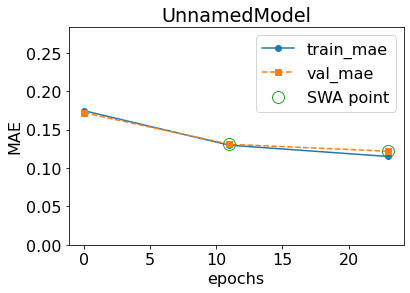

Epoch: 35/300 --- train mae: 0.103 val mae: 0.118


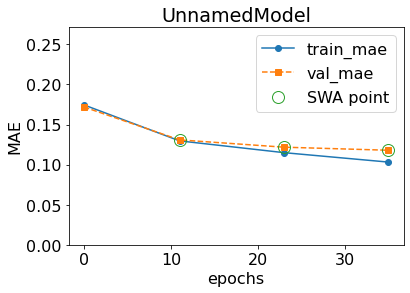

Epoch: 47/300 --- train mae: 0.0949 val mae: 0.116


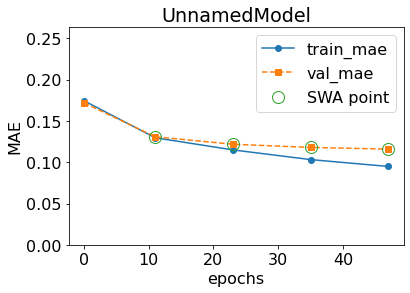

Epoch: 59/300 --- train mae: 0.0883 val mae: 0.114


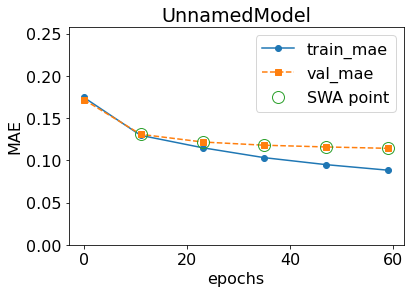

Epoch: 71/300 --- train mae: 0.0836 val mae: 0.114


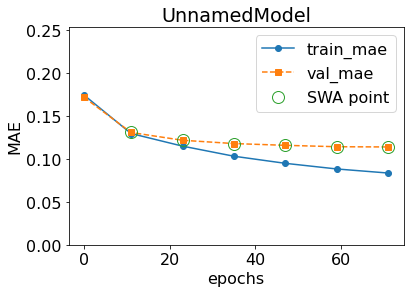

Epoch: 83/300 --- train mae: 0.0796 val mae: 0.113


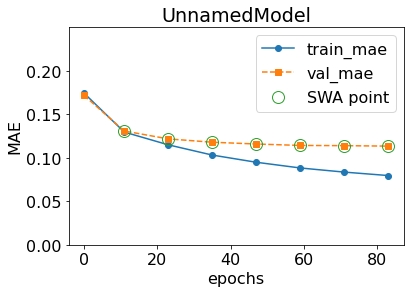

Epoch: 95/300 --- train mae: 0.0759 val mae: 0.113


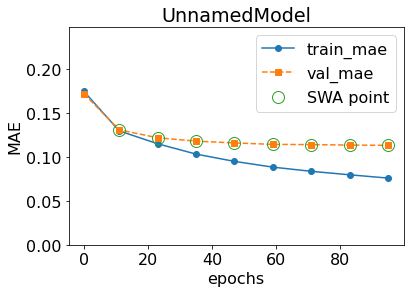

Epoch: 107/300 --- train mae: 0.0734 val mae: 0.113


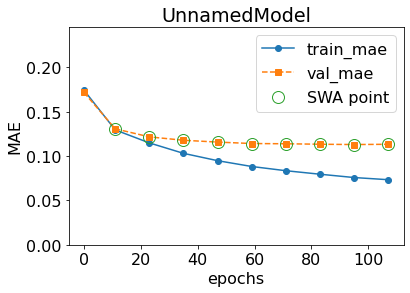

Epoch: 119/300 --- train mae: 0.0713 val mae: 0.114


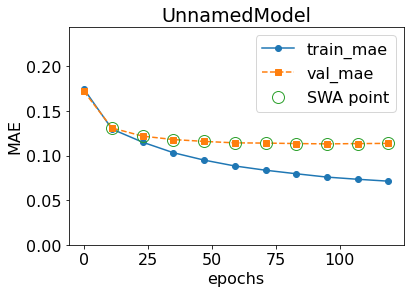

Epoch: 131/300 --- train mae: 0.0696 val mae: 0.113


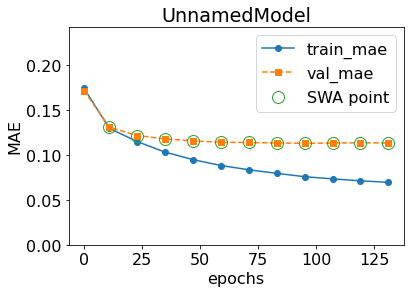

Epoch: 143/300 --- train mae: 0.068 val mae: 0.113


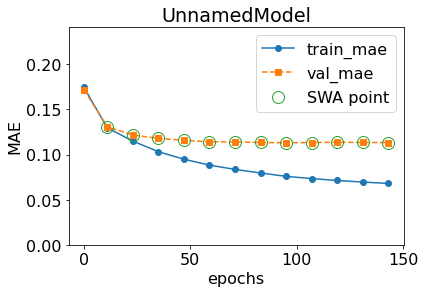

Epoch: 155/300 --- train mae: 0.0666 val mae: 0.113


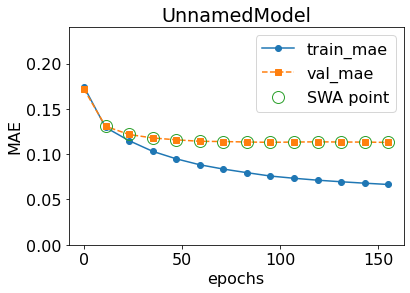

Epoch: 167/300 --- train mae: 0.0652 val mae: 0.112


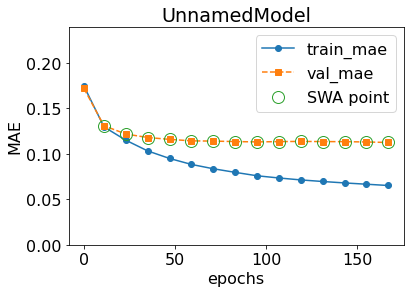

Epoch: 179/300 --- train mae: 0.0641 val mae: 0.113


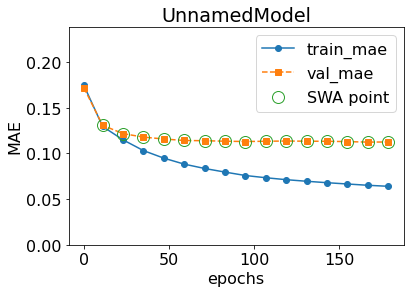

Epoch: 191/300 --- train mae: 0.0637 val mae: 0.112


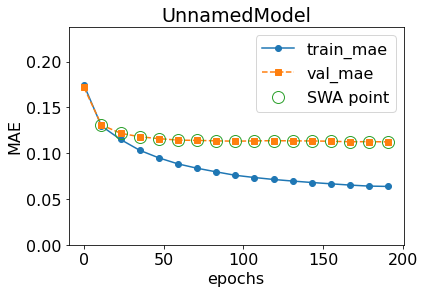

Epoch: 203/300 --- train mae: 0.0626 val mae: 0.112


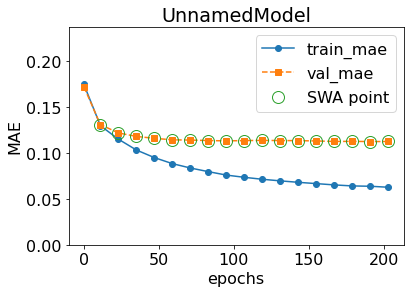

Epoch: 215/300 --- train mae: 0.0614 val mae: 0.113


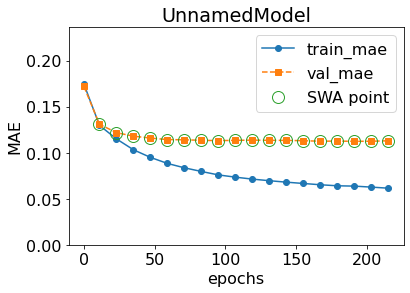

Epoch: 227/300 --- train mae: 0.0603 val mae: 0.113


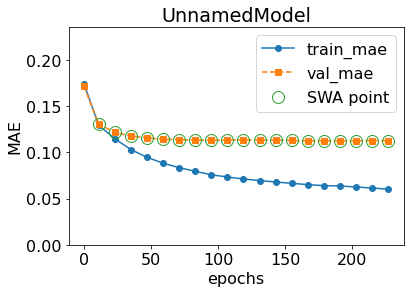

Epoch: 239/300 --- train mae: 0.0595 val mae: 0.113


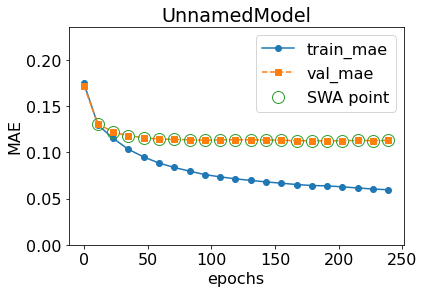

Epoch: 251/300 --- train mae: 0.059 val mae: 0.112


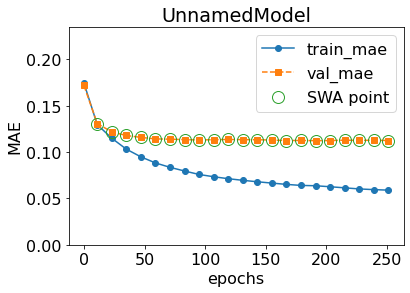

Epoch: 263/300 --- train mae: 0.0584 val mae: 0.113


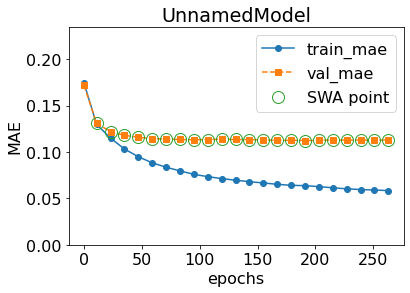

Epoch: 275/300 --- train mae: 0.0578 val mae: 0.113


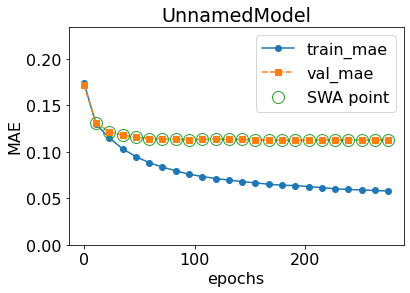

Epoch 287 failed to improve.
Discarded: 1/3 weight updates
Epoch: 287/300 --- train mae: 0.0571 val mae: 0.114


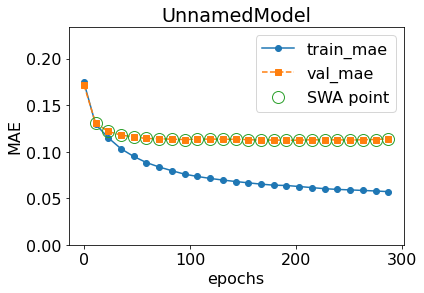

Epoch 299 failed to improve.
Discarded: 2/3 weight updates
Epoch: 299/300 --- train mae: 0.0569 val mae: 0.114


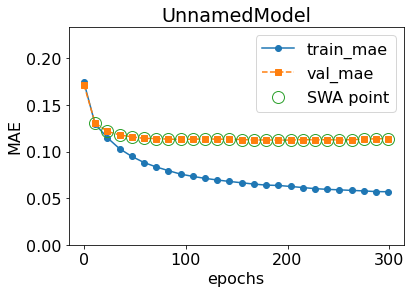

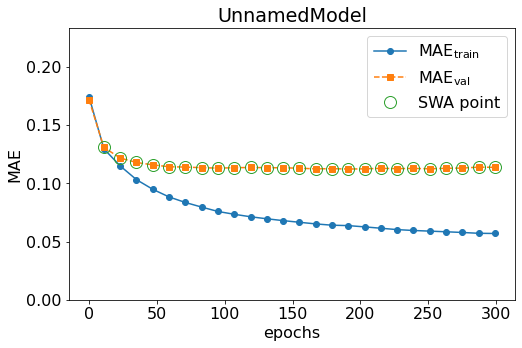

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 246573.59formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-22 14:38:56] ax.service.managed_loop: Running optimization trial 4...



Model architecture: out_dims, d_model, N, heads
3, 512, 10, 4
Running on compute device: cuda:1
Model size: 27452894 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 209585.50formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 235 (2**7.877)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 239536.54formulae/s]


loading data with up to 9 elements in the formula
stepping every 4788 training passes, cycling lr every 12 epochs
checkin at 24 epochs to match lr scheduler
300 epochs not divisible by 24 (2*epochs_step), updating epochs to 312 for learning
Epoch: 0/312 --- train mae: 0.177 val mae: 0.176


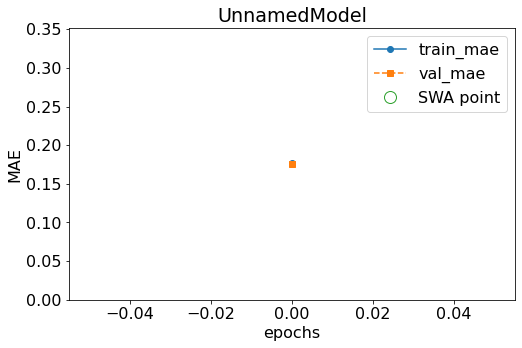

Epoch: 23/312 --- train mae: 0.113 val mae: 0.127


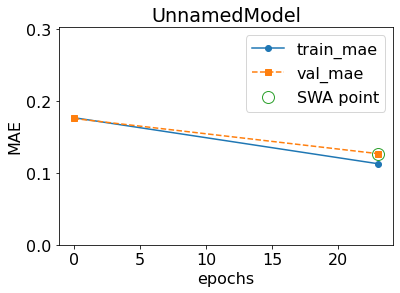

Epoch: 47/312 --- train mae: 0.0929 val mae: 0.12


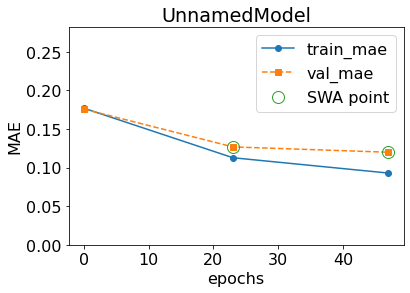

Epoch: 71/312 --- train mae: 0.0799 val mae: 0.119


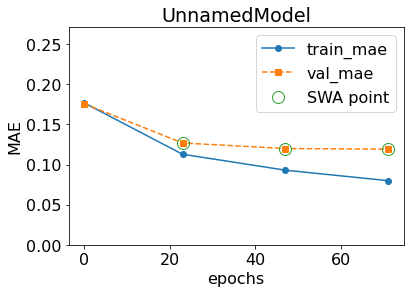

Epoch: 95/312 --- train mae: 0.0705 val mae: 0.121


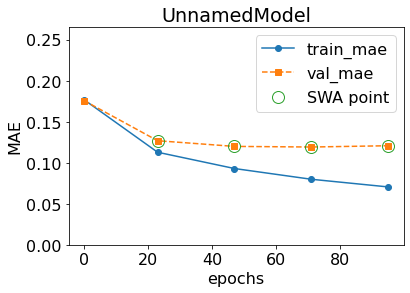

Epoch 119 failed to improve.
Discarded: 1/3 weight updates
Epoch: 119/312 --- train mae: 0.0647 val mae: 0.122


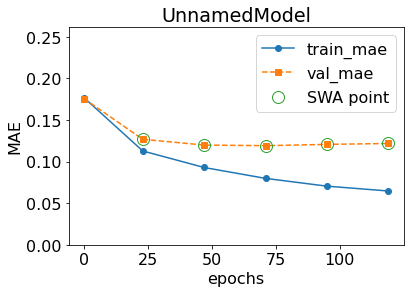

Epoch 143 failed to improve.
Discarded: 2/3 weight updates
Epoch: 143/312 --- train mae: 0.0603 val mae: 0.122


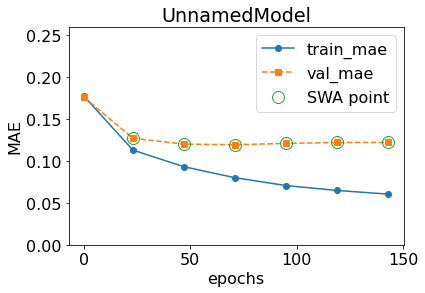

Epoch 167 failed to improve.
Discarded: 3/3 weight updates
Epoch: 167/312 --- train mae: 0.0575 val mae: 0.123


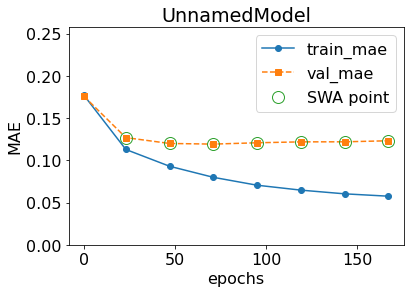

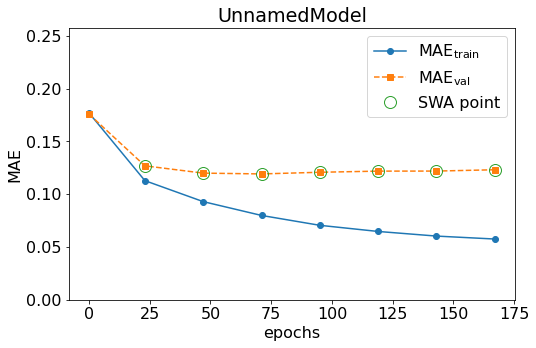

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 234449.62formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-22 19:31:55] ax.service.managed_loop: Running optimization trial 5...



Model architecture: out_dims, d_model, N, heads
3, 512, 6, 4
Running on compute device: cuda:1
Model size: 20774008 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 208654.70formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 169 (2**7.401)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 237054.65formulae/s]


loading data with up to 9 elements in the formula
stepping every 8325 training passes, cycling lr every 15 epochs
checkin at 30 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.169 val mae: 0.169


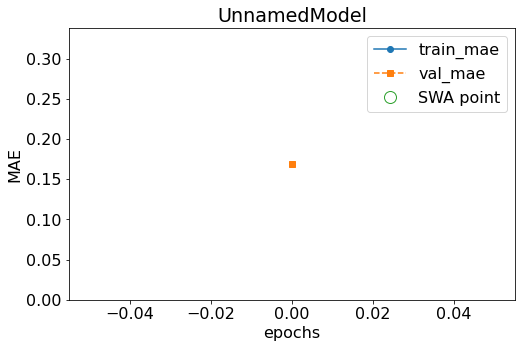

Epoch: 29/300 --- train mae: 0.116 val mae: 0.124


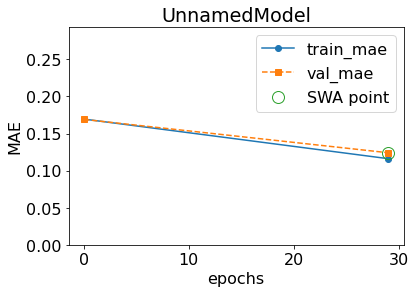

Epoch: 59/300 --- train mae: 0.1 val mae: 0.117


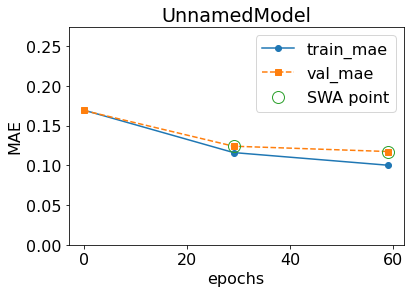

Epoch: 89/300 --- train mae: 0.0887 val mae: 0.116


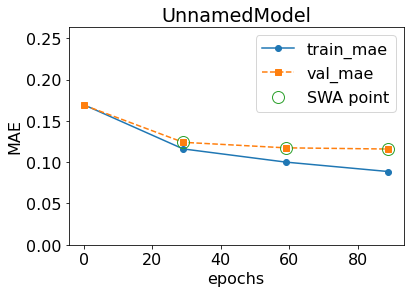

Epoch: 119/300 --- train mae: 0.0818 val mae: 0.115


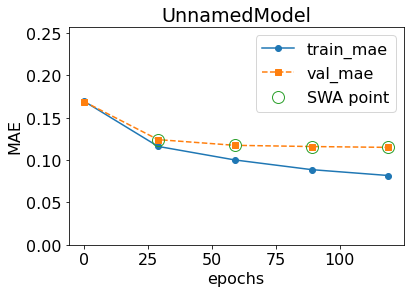

Epoch: 149/300 --- train mae: 0.0769 val mae: 0.114


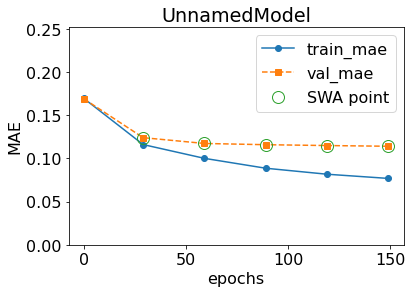

Epoch: 179/300 --- train mae: 0.0737 val mae: 0.114


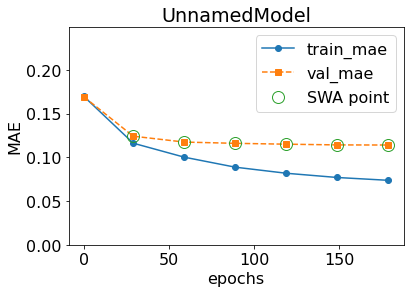

Epoch 209 failed to improve.
Discarded: 1/3 weight updates
Epoch: 209/300 --- train mae: 0.0713 val mae: 0.116


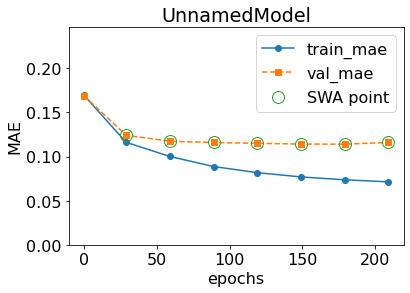

Epoch: 239/300 --- train mae: 0.0694 val mae: 0.115


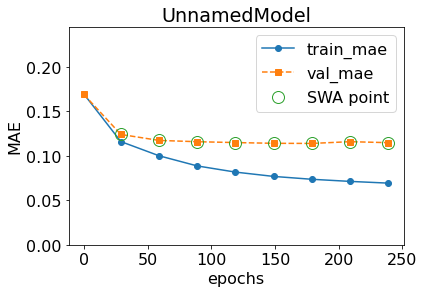

Epoch 269 failed to improve.
Discarded: 2/3 weight updates
Epoch: 269/300 --- train mae: 0.0681 val mae: 0.115


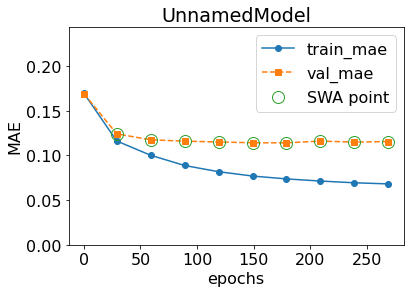

Epoch 299 failed to improve.
Discarded: 3/3 weight updates
Epoch: 299/300 --- train mae: 0.0676 val mae: 0.115


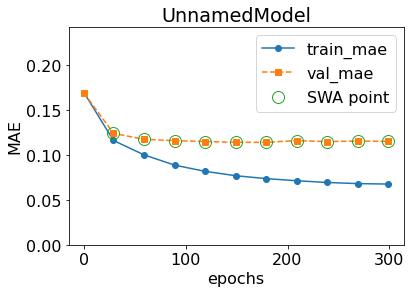

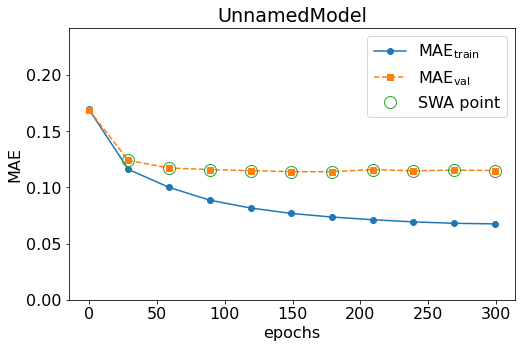

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 238612.66formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-23 03:23:11] ax.service.managed_loop: Running optimization trial 6...



Model architecture: out_dims, d_model, N, heads
3, 512, 7, 4
Running on compute device: cuda:1
Model size: 18820867 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 212821.02formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 182 (2**7.508)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 249729.91formulae/s]


loading data with up to 9 elements in the formula
stepping every 7725 training passes, cycling lr every 15 epochs
checkin at 30 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.21 val mae: 0.211


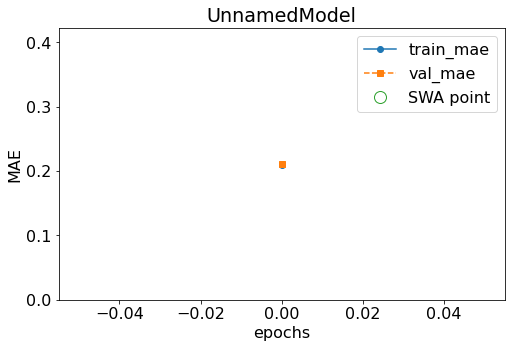

Epoch: 29/300 --- train mae: 0.17 val mae: 0.174


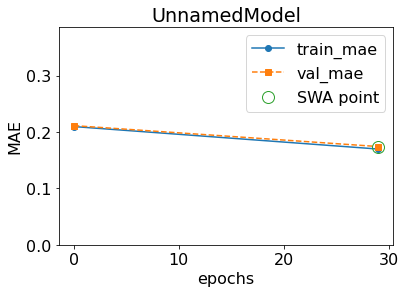

Epoch: 59/300 --- train mae: 0.156 val mae: 0.163


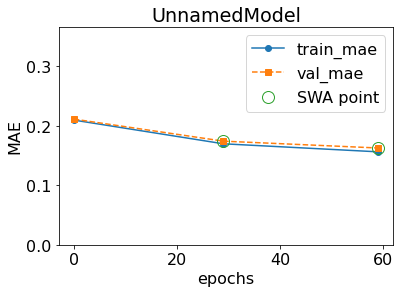

Epoch: 89/300 --- train mae: 0.145 val mae: 0.155


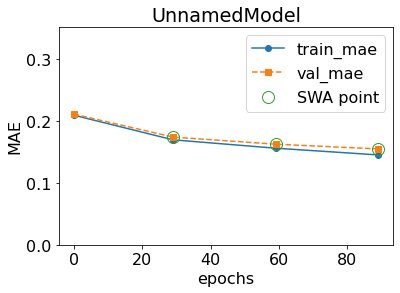

Epoch: 119/300 --- train mae: 0.14 val mae: 0.153


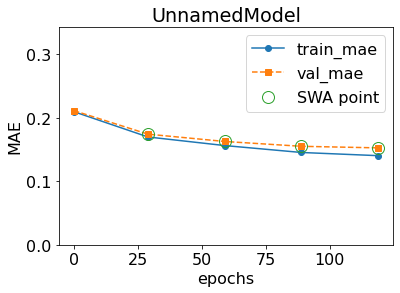

Epoch: 149/300 --- train mae: 0.136 val mae: 0.149


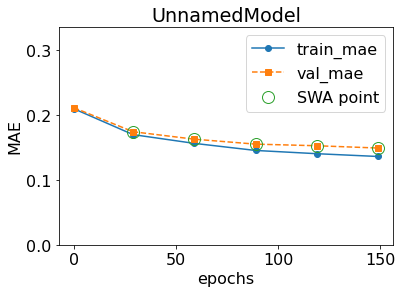

Epoch: 179/300 --- train mae: 0.135 val mae: 0.15


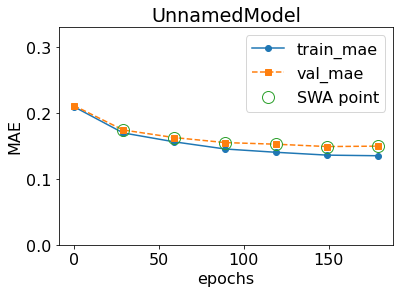

Epoch: 209/300 --- train mae: 0.133 val mae: 0.149


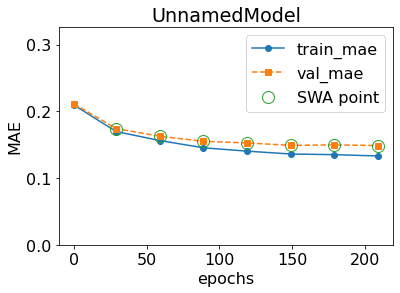

Epoch: 239/300 --- train mae: 0.13 val mae: 0.147


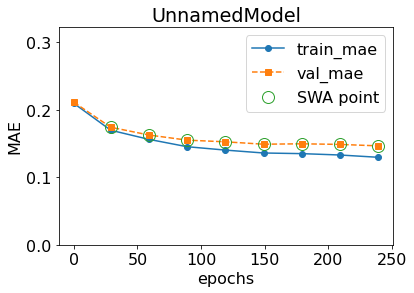

Epoch: 269/300 --- train mae: 0.131 val mae: 0.148


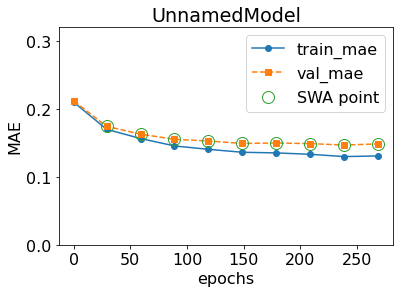

Epoch: 299/300 --- train mae: 0.128 val mae: 0.147


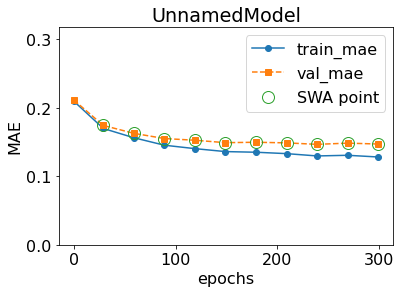

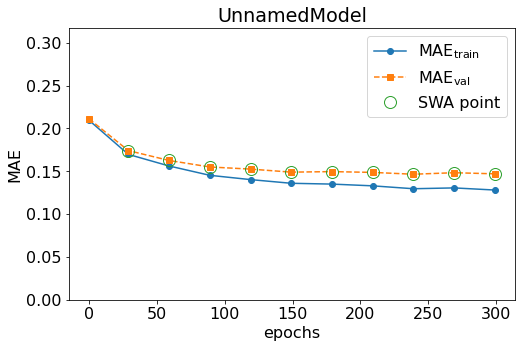

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 246462.19formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-23 11:02:47] ax.service.managed_loop: Running optimization trial 7...



Model architecture: out_dims, d_model, N, heads
3, 512, 8, 4
Running on compute device: cuda:1
Model size: 39975326 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 206815.84formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 189 (2**7.562)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 234746.50formulae/s]


loading data with up to 9 elements in the formula
stepping every 8432 training passes, cycling lr every 17 epochs
checkin at 34 epochs to match lr scheduler
300 epochs not divisible by 34 (2*epochs_step), updating epochs to 306 for learning
Epoch: 0/306 --- train mae: 0.204 val mae: 0.202


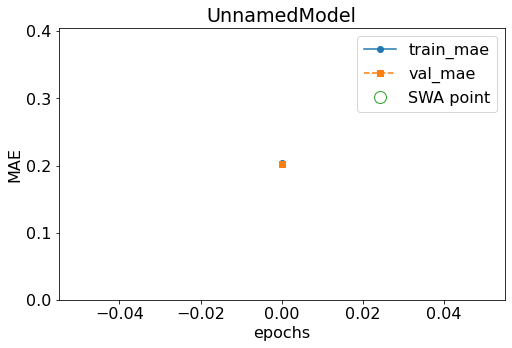

Epoch: 33/306 --- train mae: 0.226 val mae: 0.224


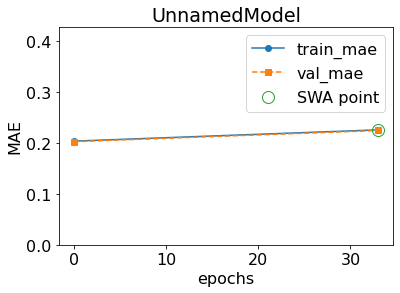

Epoch: 67/306 --- train mae: 0.225 val mae: 0.224


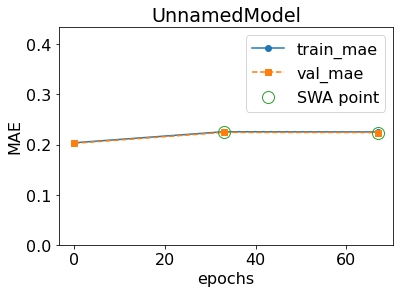

Epoch: 101/306 --- train mae: 0.225 val mae: 0.223


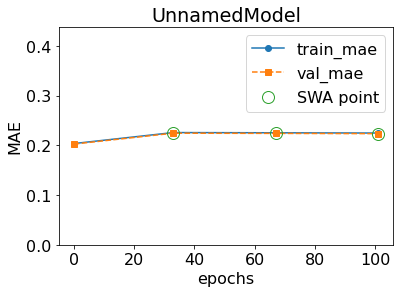

Epoch: 135/306 --- train mae: 0.225 val mae: 0.224


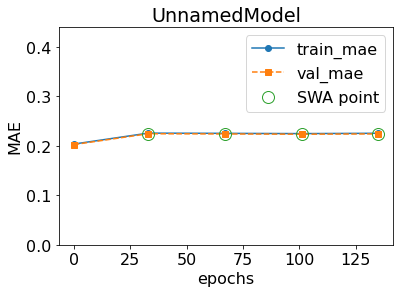

Epoch: 169/306 --- train mae: 0.226 val mae: 0.225


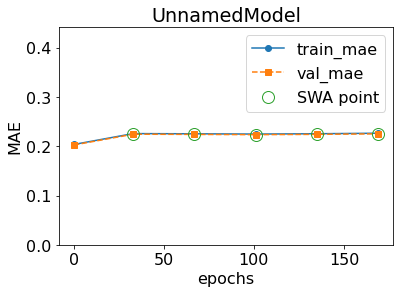

Epoch 203 failed to improve.
Discarded: 1/3 weight updates
Epoch: 203/306 --- train mae: 0.227 val mae: 0.226


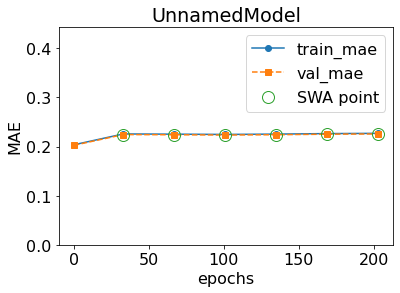

Epoch: 237/306 --- train mae: 0.225 val mae: 0.224


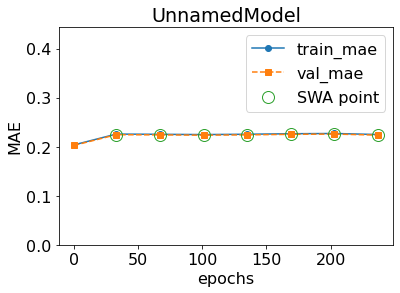

Epoch: 271/306 --- train mae: 0.227 val mae: 0.226


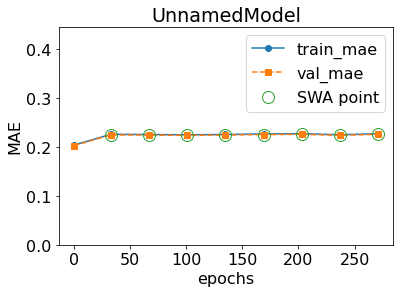

Epoch: 305/306 --- train mae: 0.226 val mae: 0.225


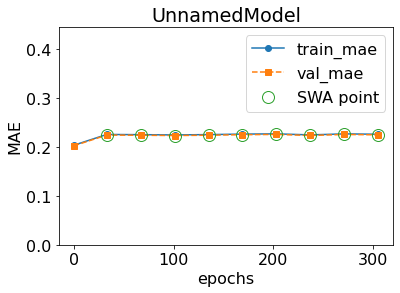

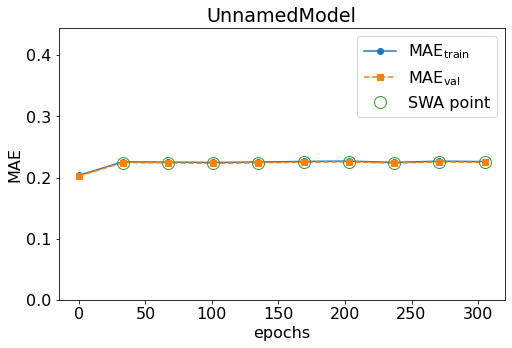

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 231019.19formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-23 20:50:03] ax.service.managed_loop: Running optimization trial 8...



Model architecture: out_dims, d_model, N, heads
3, 512, 6, 4
Running on compute device: cuda:1
Model size: 24353308 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 209104.82formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 235 (2**7.877)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 237186.35formulae/s]


loading data with up to 9 elements in the formula
stepping every 6783 training passes, cycling lr every 17 epochs
checkin at 34 epochs to match lr scheduler
300 epochs not divisible by 34 (2*epochs_step), updating epochs to 306 for learning
Epoch: 0/306 --- train mae: 0.227 val mae: 0.223


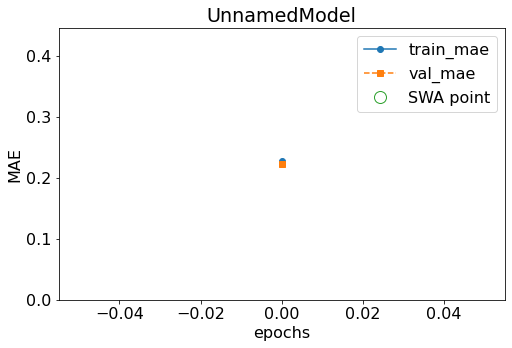

Epoch: 33/306 --- train mae: 0.171 val mae: 0.169


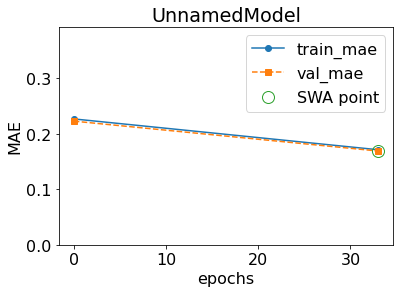

Epoch: 67/306 --- train mae: 0.153 val mae: 0.155


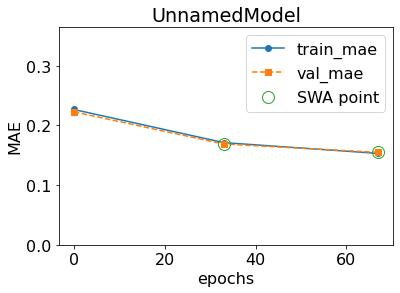

Epoch: 101/306 --- train mae: 0.144 val mae: 0.148


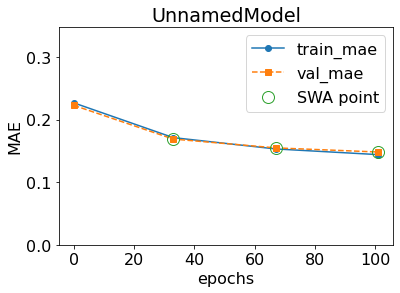

Epoch: 135/306 --- train mae: 0.14 val mae: 0.145


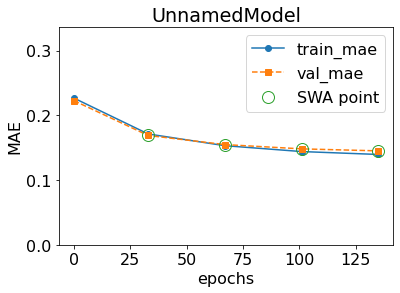

Epoch: 169/306 --- train mae: 0.133 val mae: 0.14


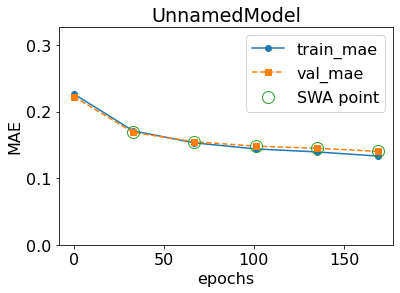

Epoch: 203/306 --- train mae: 0.129 val mae: 0.138


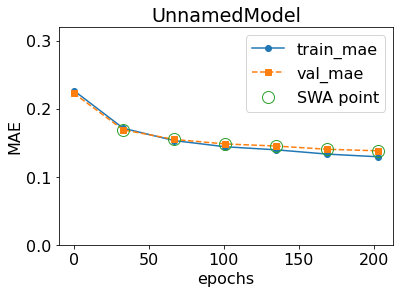

Epoch 237 failed to improve.
Discarded: 1/3 weight updates
Epoch: 237/306 --- train mae: 0.13 val mae: 0.141


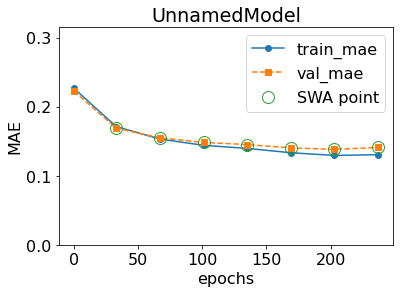

Epoch: 271/306 --- train mae: 0.129 val mae: 0.139


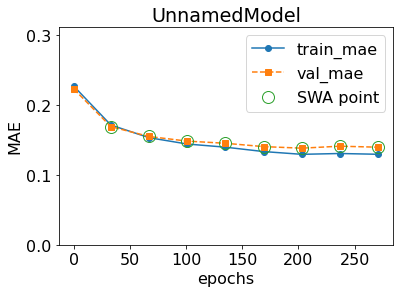

Epoch: 305/306 --- train mae: 0.127 val mae: 0.138


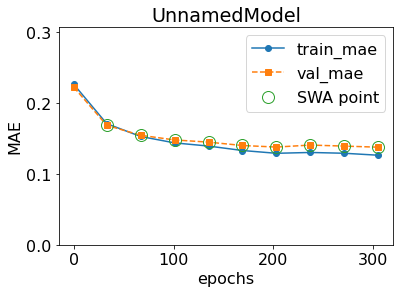

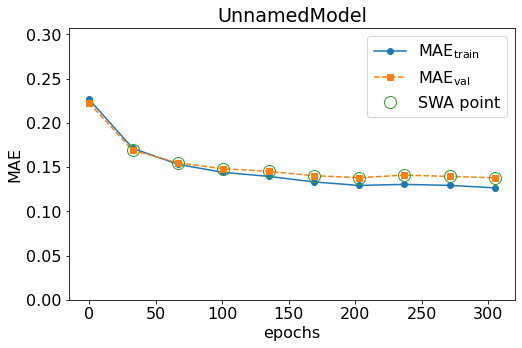

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 232817.99formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-24 02:44:41] ax.service.managed_loop: Running optimization trial 9...



Model architecture: out_dims, d_model, N, heads
3, 512, 10, 4
Running on compute device: cuda:1
Model size: 48045144 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 208653.82formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 147 (2**7.200)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 249731.81formulae/s]


loading data with up to 9 elements in the formula
stepping every 5104 training passes, cycling lr every 8 epochs
checkin at 16 epochs to match lr scheduler
300 epochs not divisible by 16 (2*epochs_step), updating epochs to 304 for learning
Epoch: 0/304 --- train mae: 0.228 val mae: 0.226


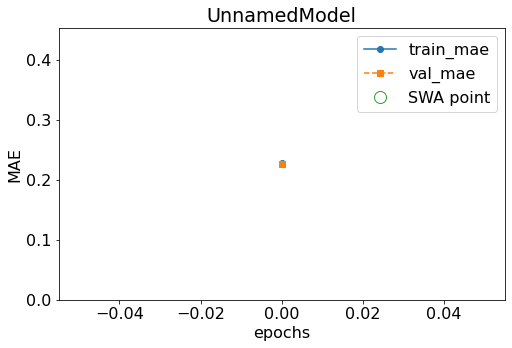

Epoch: 15/304 --- train mae: 0.226 val mae: 0.224


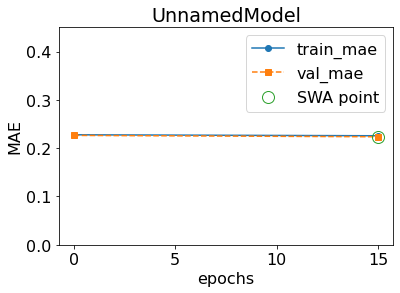

Epoch: 31/304 --- train mae: 0.225 val mae: 0.223


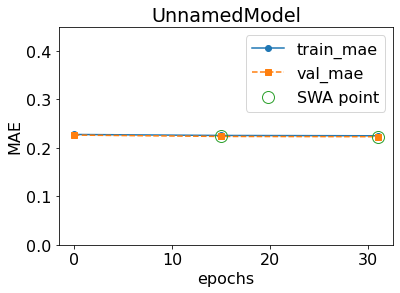

Epoch: 47/304 --- train mae: 0.225 val mae: 0.223


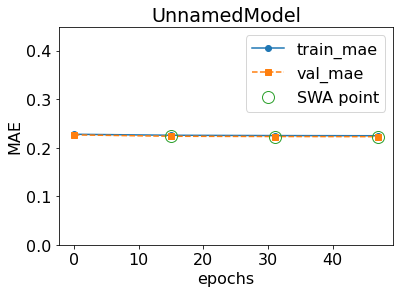

Epoch: 63/304 --- train mae: 0.224 val mae: 0.222


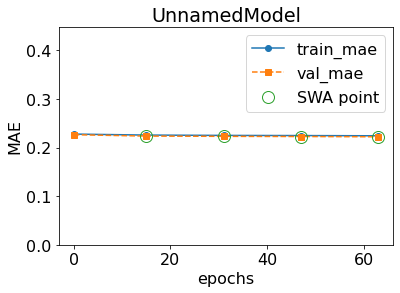

Epoch: 79/304 --- train mae: 0.224 val mae: 0.222


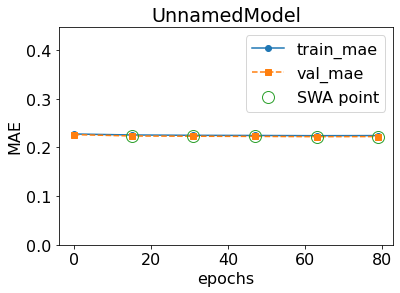

Epoch: 95/304 --- train mae: 0.223 val mae: 0.221


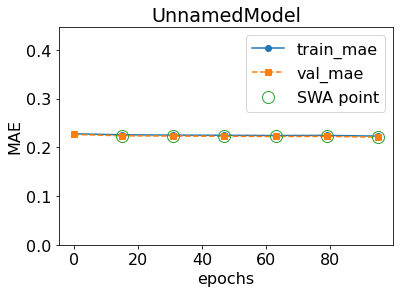

Epoch: 111/304 --- train mae: 0.228 val mae: 0.226


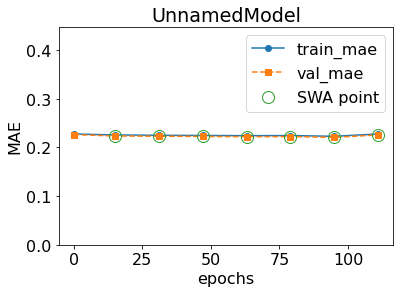

Epoch: 127/304 --- train mae: 0.227 val mae: 0.225


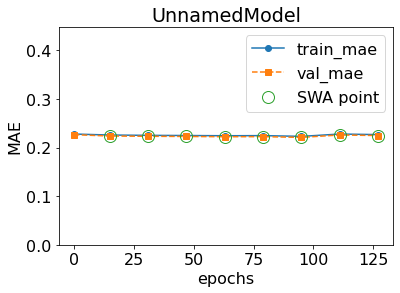

Epoch 143 failed to improve.
Discarded: 1/3 weight updates
Epoch: 143/304 --- train mae: 0.229 val mae: 0.227


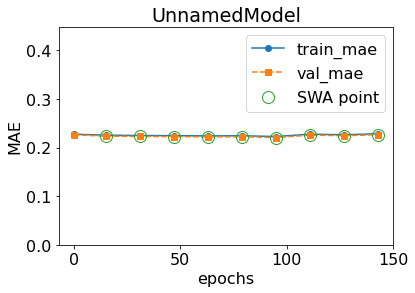

Epoch: 159/304 --- train mae: 0.226 val mae: 0.224


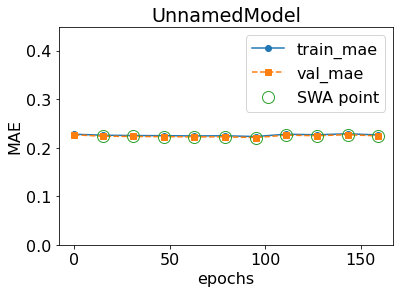

Epoch 175 failed to improve.
Discarded: 2/3 weight updates
Epoch: 175/304 --- train mae: 0.229 val mae: 0.227


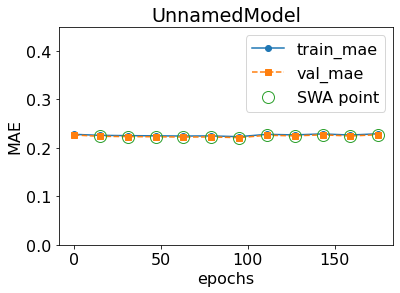

Epoch 191 failed to improve.
Discarded: 3/3 weight updates
Epoch: 191/304 --- train mae: 0.231 val mae: 0.229


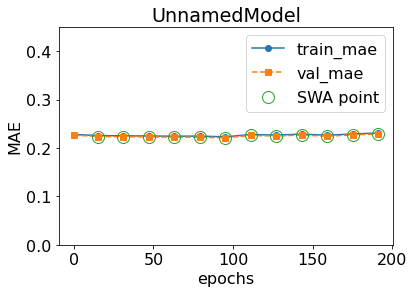

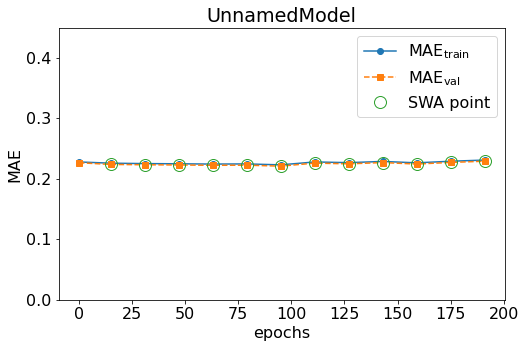

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 223982.37formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-24 16:48:11] ax.service.managed_loop: Running optimization trial 10...



Model architecture: out_dims, d_model, N, heads
3, 512, 10, 4
Running on compute device: cuda:1
Model size: 45831144 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 210484.59formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 167 (2**7.384)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 246875.11formulae/s]


loading data with up to 9 elements in the formula
stepping every 4488 training passes, cycling lr every 8 epochs
checkin at 16 epochs to match lr scheduler
300 epochs not divisible by 16 (2*epochs_step), updating epochs to 304 for learning
Epoch: 0/304 --- train mae: 0.222 val mae: 0.22


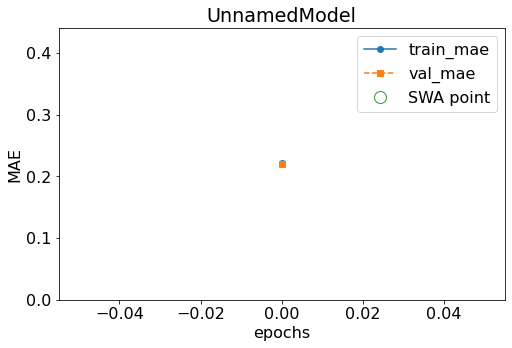

Epoch: 15/304 --- train mae: 0.221 val mae: 0.22


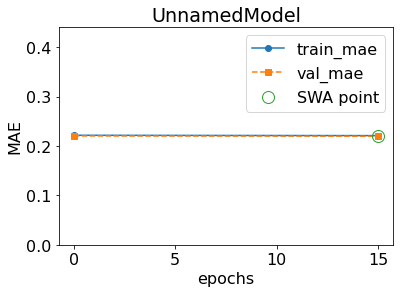

Epoch: 31/304 --- train mae: 0.197 val mae: 0.198


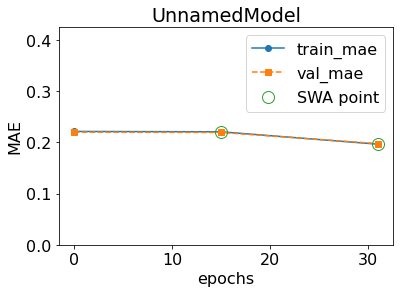

Epoch: 47/304 --- train mae: 0.19 val mae: 0.192


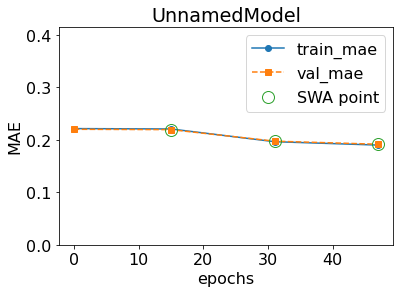

Epoch: 63/304 --- train mae: 0.18 val mae: 0.182


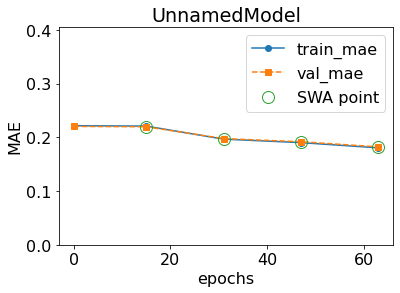

Epoch: 79/304 --- train mae: 0.173 val mae: 0.176


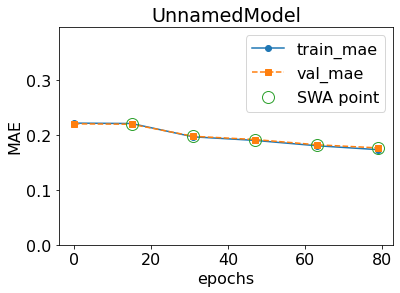

Epoch: 95/304 --- train mae: 0.166 val mae: 0.171


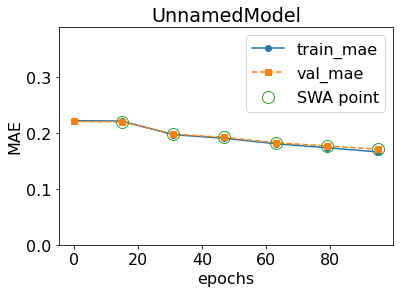

Epoch: 111/304 --- train mae: 0.159 val mae: 0.165


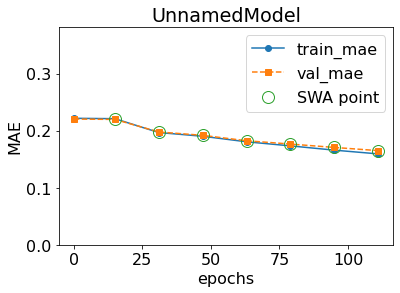

Epoch: 127/304 --- train mae: 0.154 val mae: 0.161


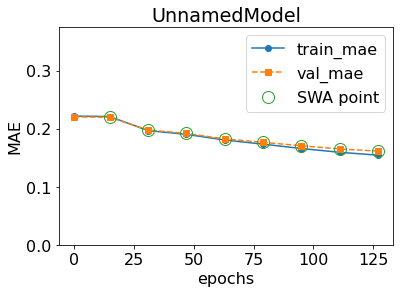

Epoch: 143/304 --- train mae: 0.149 val mae: 0.157


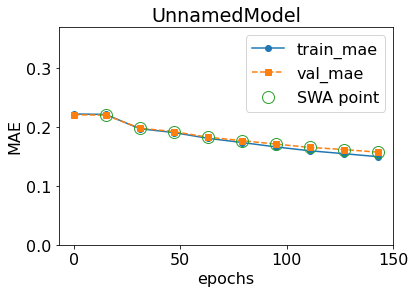

Epoch: 159/304 --- train mae: 0.143 val mae: 0.153


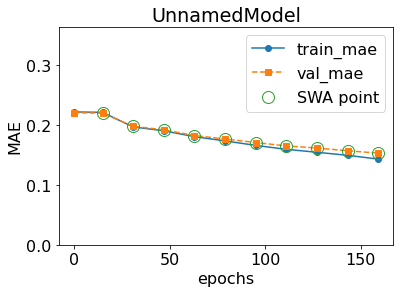

Epoch: 175/304 --- train mae: 0.138 val mae: 0.149


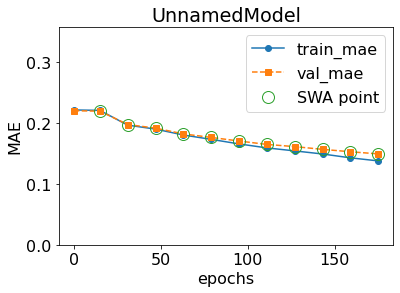

Epoch: 191/304 --- train mae: 0.134 val mae: 0.148


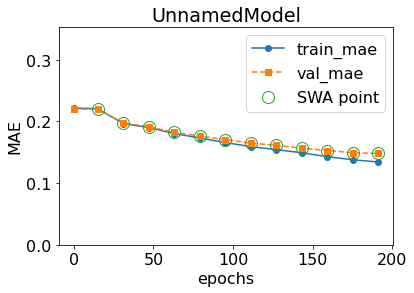

Epoch: 207/304 --- train mae: 0.129 val mae: 0.146


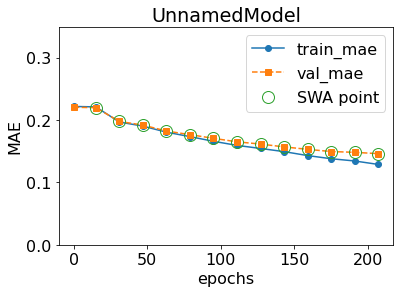

Epoch: 223/304 --- train mae: 0.127 val mae: 0.145


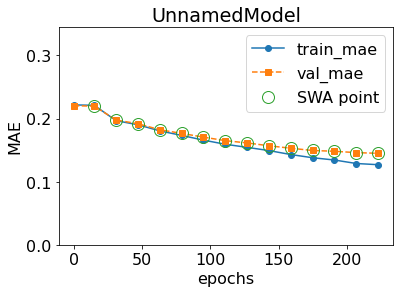

Epoch: 239/304 --- train mae: 0.122 val mae: 0.142


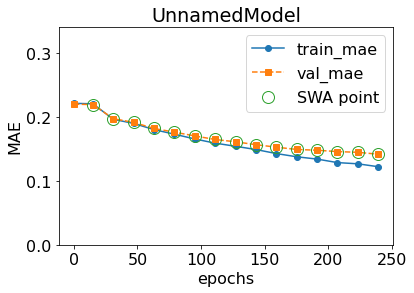

Epoch: 255/304 --- train mae: 0.119 val mae: 0.14


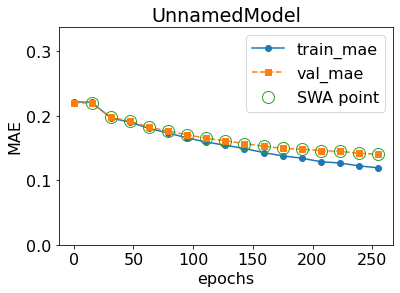

Epoch: 271/304 --- train mae: 0.116 val mae: 0.139


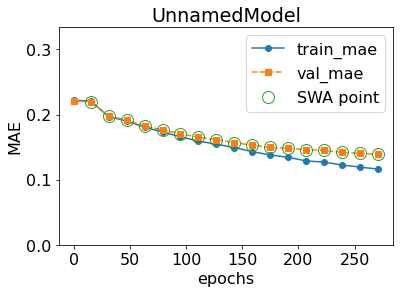

Epoch: 287/304 --- train mae: 0.113 val mae: 0.138


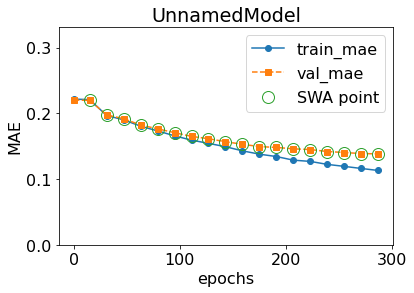

Epoch: 303/304 --- train mae: 0.11 val mae: 0.137


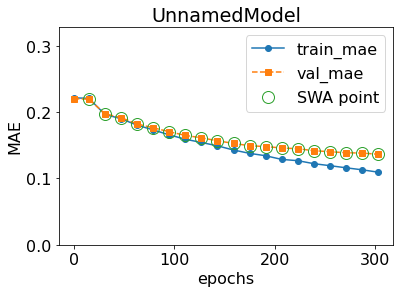

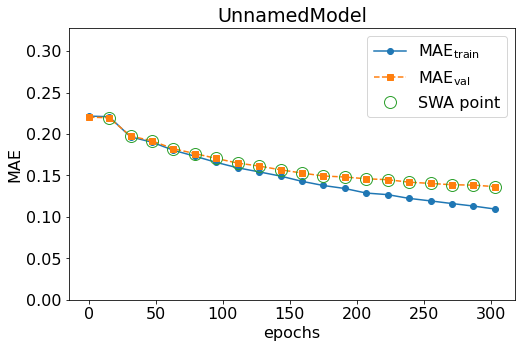

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 234612.29formulae/s]


loading data with up to 9 elements in the formula
{'batch_size': 99, 'fudge': 0.005643535312265158, 'N': 4, 'emb_scaler': 0.9899460608139634, 'bias': False, 'dim_feedforward': 3921, 'dropout': 0.8085935013368726, 'epochs_step': 6, 'pe_resolution': 7171, 'ple_resolution': 7801, 'lr': 0.0013353348506614565, 'eps': 7.345653758859263e-05, 'weight_decay': 0.26797659788280725, 'alpha': 0.2784038567915559, 'k': 6, 'elem_prop': 'mat2vec', 'criterion': 'RobustL1'}
({'mae': 0.11023708097339713}, {'mae': {'mae': nan}})


In [12]:
best_parameters, best_values, experiment, model = optimize(
        parameters=[
          {"name": "batch_size", "type": "range", "bounds": [32, 256]},
          {"name": "fudge", "type": "range", "bounds": [0.0, 0.1]},
          # {"name": "d_model", "type": "range", "bounds": [100, 1024]},
          {"name": "N", "type": "range", "bounds": [1, 10]},
          # {"name": "heads", "type": "range", "bounds": [1, 10]},
          # {"name": "out_hidden4", "type": "range", "bounds": [32, 512]},
          {"name": "emb_scaler", "type": "range", "bounds": [0.0, 1.0]},
          # {"name": "pos_scaler", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "bias", "type": "choice", "values": [False, True]},
          {"name": "dim_feedforward", "type": "range", "bounds": [1024, 4096],},
          {"name": "dropout", "type": "range", "bounds": [0.0, 1.0]},
          {
            "name": "elem_prop",
            "type": "choice",
            "values": ["mat2vec",
                    "oliynyk",
                    "magpie",
                    "onehot",],
          },
          {"name": "epochs_step", "type": "range", "bounds": [5, 20]},
          {"name": "pe_resolution", "type": "range", "bounds": [2500, 10000]},
          {"name": "ple_resolution", "type": "range", "bounds": [2500, 10000],},
          {
            "name": "criterion",
            "type": "choice",
            "values": ["RobustL1", "RobustL2"],
          },
          {"name": "lr", "type": "range", "bounds": [0.0001, 0.006]},
          # {"name": "betas1", "type": "range", "bounds": [0.5, 0.9999]},
          # {"name": "betas2", "type": "range", "bounds": [0.5, 0.9999]},
          {"name": "eps", "type": "range", "bounds": [0.0000001, 0.0001]},
          {"name": "weight_decay", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "alpha", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "k", "type": "range", "bounds": [2, 10]},
        ],
        experiment_name="crabnet-hyperparameter_tuning",
        evaluation_function=crabnet_evaluation,
        objective_name="mae",
        minimize=True,
        # parameter_constraints=["betas1 <= betas2", "emb_scaler + pos_scaler <= 1"],
        total_trials= 10)

print(best_parameters)
print(best_values)

# default_model= CrabNet(force_cpu=False, epochs=300)
# default_model.fit(df_train)
# default_y_predicted= default_model.predict(df_test)
# default_mae = mean_absolute_error(df_test['target'].to_list(), default_y_predicted)

# del default_model
# gc.collect()
# torch.cuda.empty_cache()

# best_parameterization = correct_parameterization(best_parameters)
# test_model = CrabNet(**best_parameterization, force_cpu=False, epochs=300)
# test_model.fit(df_train)
# test_y_predicted= test_model.predict(df_test)
# test_mae = mean_absolute_error(df_test['target'].to_list(), test_y_predicted)

# del test_model
# gc.collect()
# torch.cuda.empty_cache()

##Training CrabNet for e_above_hull


Model architecture: out_dims, d_model, N, heads
3, 512, 4, 4
Running on compute device: cuda
Model size: 22818890 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 215251.88formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 99 (2**6.629)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 249660.06formulae/s]


loading data with up to 9 elements in the formula
stepping every 5676 training passes, cycling lr every 6 epochs
checkin at 12 epochs to match lr scheduler
500 epochs not divisible by 12 (2*epochs_step), updating epochs to 504 for learning
Epoch: 0/504 --- train mae: 0.174 val mae: 0.178


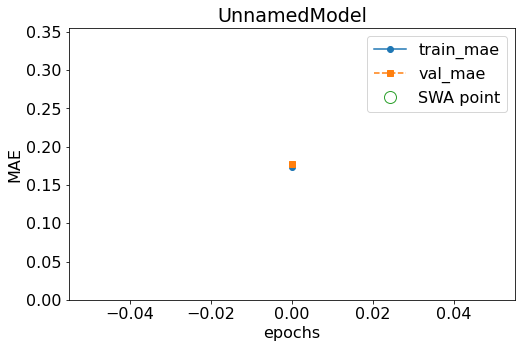

Epoch: 11/504 --- train mae: 0.128 val mae: 0.136


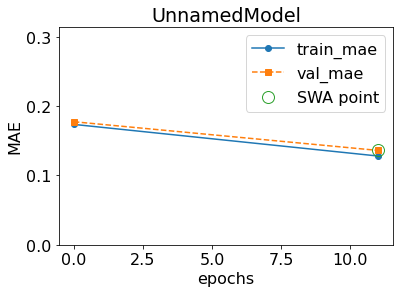

Epoch: 23/504 --- train mae: 0.114 val mae: 0.127


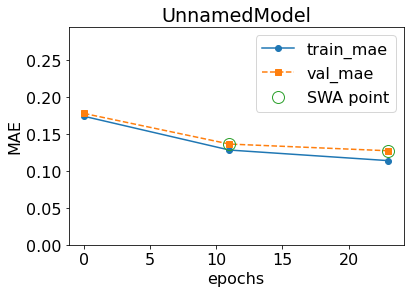

Epoch: 35/504 --- train mae: 0.103 val mae: 0.122


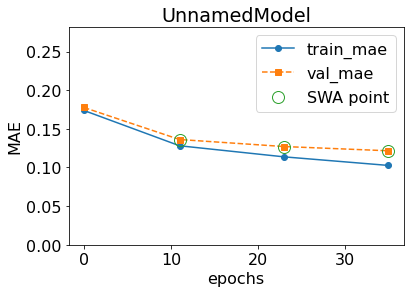

Epoch: 47/504 --- train mae: 0.0946 val mae: 0.119


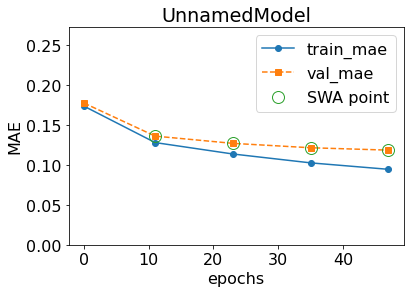

Epoch: 59/504 --- train mae: 0.0882 val mae: 0.116


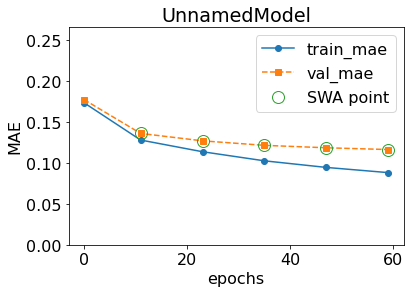

Epoch: 71/504 --- train mae: 0.0825 val mae: 0.116


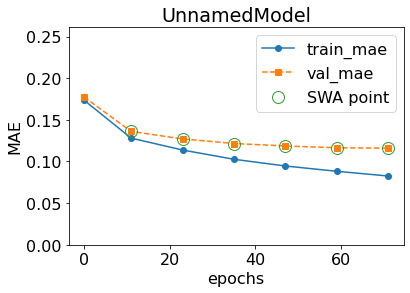

Epoch: 83/504 --- train mae: 0.0785 val mae: 0.116


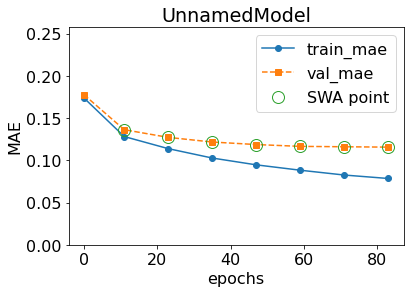

Epoch: 95/504 --- train mae: 0.0752 val mae: 0.115


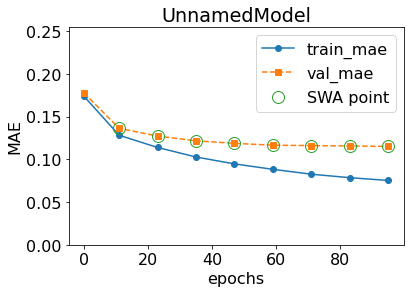

Epoch: 107/504 --- train mae: 0.072 val mae: 0.115


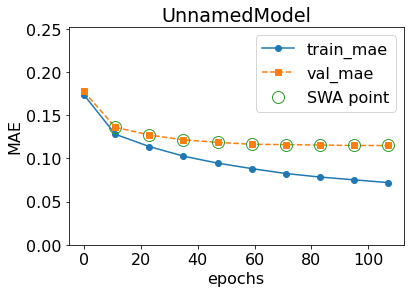

Epoch: 119/504 --- train mae: 0.0696 val mae: 0.115


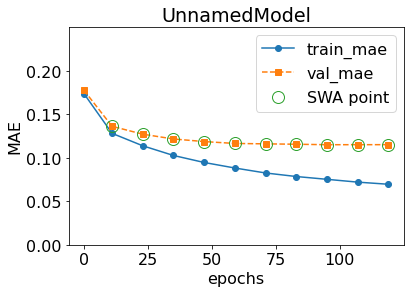

Epoch: 131/504 --- train mae: 0.0675 val mae: 0.115


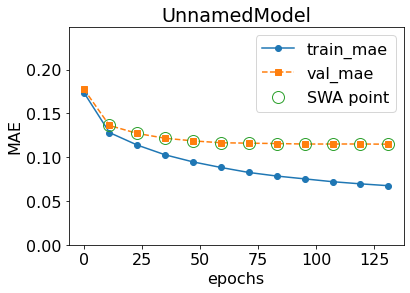

Epoch: 143/504 --- train mae: 0.0662 val mae: 0.115


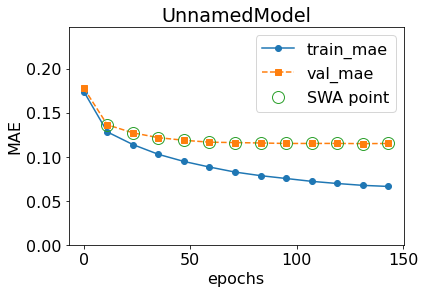

Epoch: 155/504 --- train mae: 0.0643 val mae: 0.115


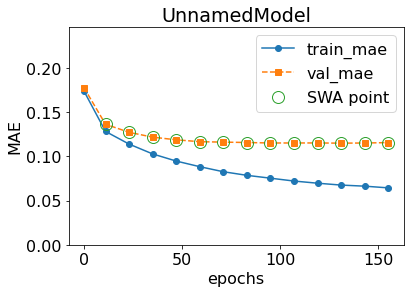

Epoch: 167/504 --- train mae: 0.0632 val mae: 0.115


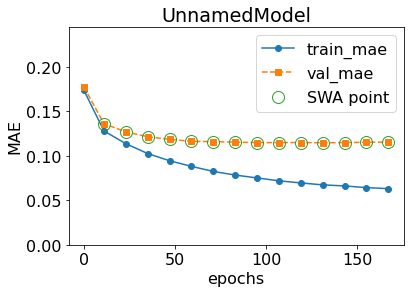

Epoch: 179/504 --- train mae: 0.0617 val mae: 0.116


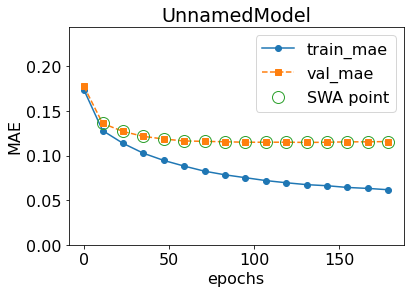

Epoch 191 failed to improve.
Discarded: 1/3 weight updates
Epoch: 191/504 --- train mae: 0.0611 val mae: 0.116


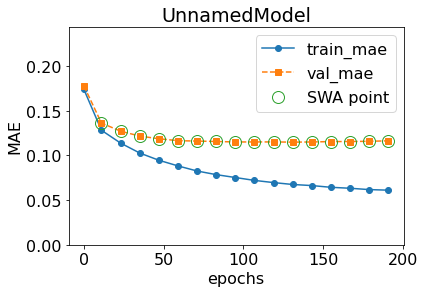

Epoch: 203/504 --- train mae: 0.0605 val mae: 0.116


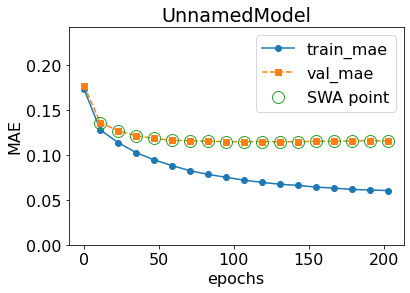

Epoch: 215/504 --- train mae: 0.0599 val mae: 0.116


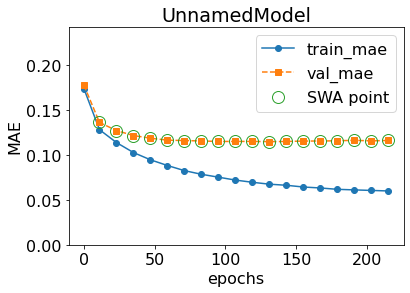

Epoch: 227/504 --- train mae: 0.0591 val mae: 0.116


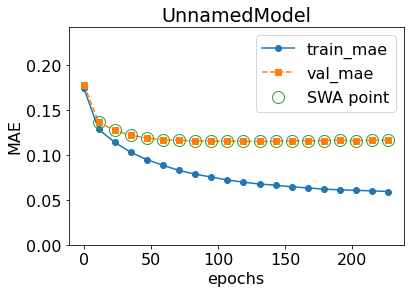

Epoch 239 failed to improve.
Discarded: 2/3 weight updates
Epoch: 239/504 --- train mae: 0.0583 val mae: 0.117


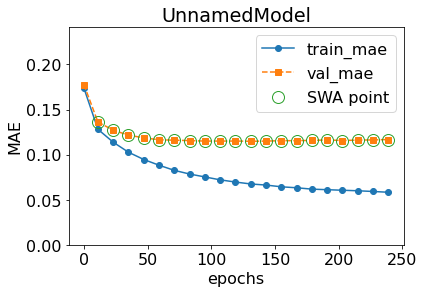

Epoch 251 failed to improve.
Discarded: 3/3 weight updates
Epoch: 251/504 --- train mae: 0.0576 val mae: 0.117


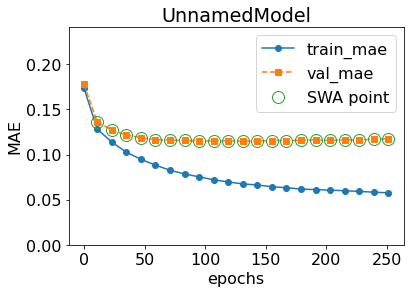

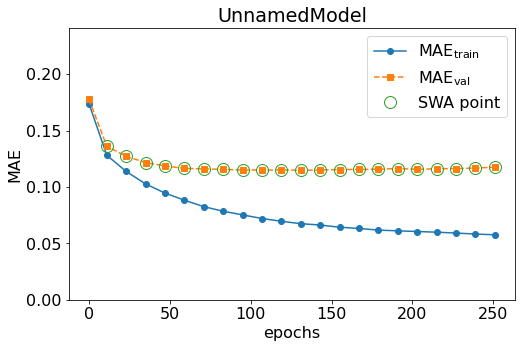

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 248658.60formulae/s]


loading data with up to 9 elements in the formula


In [13]:
# best_parameterization = correct_parameterization(best_parameters)
cb_e = CrabNet(mat_prop="e_above_hull", compute_device="cuda", **best_parameters, epochs = 500)
cb_e.fit(df_train_e)
val_pred_e, val_sigma_e = cb_e.predict(df_test_e, return_uncertainty=True)

##Predict energy above hull for our predicted materials

Place the file named peak_score.csv directly in your MyDrive folder or in your current directory.

In [17]:
test_data_fpath = "C:/Users/Hasan Sayeed/Documents/hasan/DISCOVER/peak_score.csv"      # "/content/drive/MyDrive/peak_score.csv"

with open(test_data_fpath, 'r') as f:
    test_df_e = pd.read_csv(test_data_fpath, sep=",")

test_pred_e, test_sigma_e = cb_e.predict(test_df_e, return_uncertainty=True)

test_df_e["predicted_e_above_hull"] = test_pred_e
test_df_e["uncertainty_for_e_above_hull"] = test_sigma_e
print(test_df_e)
test_df_e.to_csv("intermediate.csv")

Generating EDM: 100%|██████████| 100000/100000 [00:00<00:00, 224309.93formulae/s]


loading data with up to 9 elements in the formula
                 formula  prediction    density      score is_valid  target  \
0                CaCu4Sb  150.656235   3.385642  29.250681     True       0   
1               CaAl2O12  132.798248   6.247991  25.816469     True       0   
2               Ca(NO5)2  135.998795   6.453689  25.167288    False       0   
3                  YCu13  125.323814   6.211921  25.133519     True       0   
4               Ca(IO6)2  134.643600   6.899210  24.973459     True       0   
...                  ...         ...        ...        ...      ...     ...   
99995            Na3SiPt    7.122471   0.889169   0.883617    False       0   
99996  HgH10C12Br2(N2O)2    7.033318   1.352084   0.883612     True       0   
99997             Ba3CaP    6.837135   1.043855   0.883596     True       0   
99998             MgB2Pt   12.045229  16.268454   0.883594     True       0   
99999     Li15GeP(S3Cl)3    7.572525   3.375655   0.883591    False       0   

 

##Getting training and validation datasets for stability

In [18]:
# formula = []
# target = []

# for s in tqdm(docs):
#     f = s.formula_pretty
#     st = s.theoretical
#     formula.append(f)
#     if st:
#       target.append(1)
#     else:
#       target.append(0)
  
# df_st = pd.DataFrame(list(zip(formula, target)), columns =['formula', 'target'])

# train_df_st, val_df_st = train_test_split(df_st, test_size=0.20, random_state=42)


train_data_fpath = "C:/Users/Hasan Sayeed/Documents/hasan/DISCOVER/stability.csv"     # "/content/drive/MyDrive/stability.csv"

with open(train_data_fpath, 'r') as f:
    df_st = pd.read_csv(train_data_fpath, sep=",")

In [19]:
df_st = df_st[df_st['formula'].apply(lambda x: isinstance(x, (str)))]

In [20]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(df_st['formula'], df_st['target'], test_size=0.20, random_state=42)
# train_df_st, val_df_st = train_test_split(df_st, test_size=0.20, random_state=42)

In [21]:
df_train_st = pd.DataFrame({"formula": X_train_st, "target": y_train_st})
df_test_st = pd.DataFrame({"formula": X_test_st, "target": y_test_st})

## Optimizing CrabNet with AX for stability prediction

In [24]:
def crabnet_evaluation(parameterization):
        """Compute the RMSE of a CrabNet model."""
        # parameterization = correct_parameterization(parameterization)
        model= CrabNet(**parameterization, force_cpu=False, classification=True, epochs=300)
        model.fit(df_train_st)
        y_predicted= model.predict(df_test_st)

        mae = mean_absolute_error(df_test_st['target'].to_list(), y_predicted)
        
        # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
        del model
        gc.collect()
        torch.cuda.empty_cache()


        return {"mae":mae}

[INFO 09-26 10:40:13] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-26 10:40:13] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter fudge. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-26 10:40:13] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter N. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-26 10:40:13] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter emb_scaler. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:1
Model size: 12077922 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 203234.50formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 251 (2**7.972)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 230238.72formulae/s]


loading data with up to 9 elements in the formula
stepping every 2992 training passes, cycling lr every 8 epochs
checkin at 16 epochs to match lr scheduler
300 epochs not divisible by 16 (2*epochs_step), updating epochs to 304 for learning
Epoch: 0/304 --- train mae: 0.378 val mae: 0.378


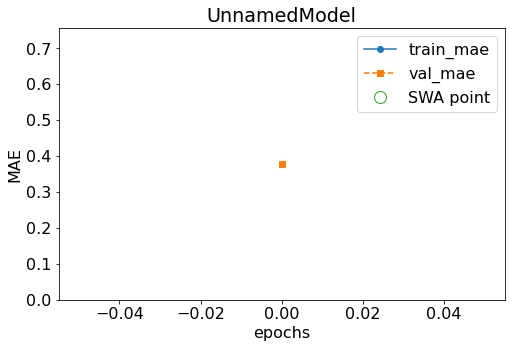

Epoch: 15/304 --- train mae: 0.341 val mae: 0.342


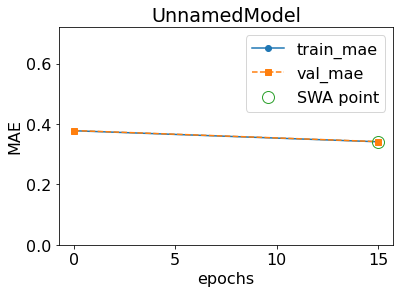

Epoch: 31/304 --- train mae: 0.34 val mae: 0.34


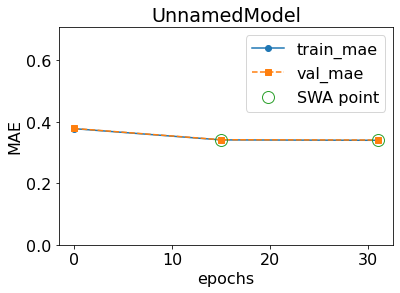

Epoch: 47/304 --- train mae: 0.337 val mae: 0.337


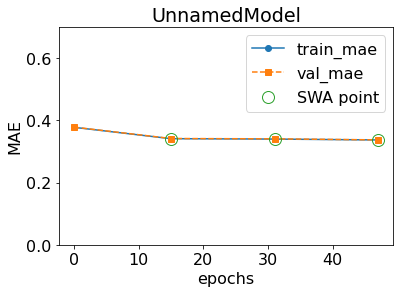

Epoch 63 failed to improve.
Discarded: 1/3 weight updates
Epoch: 63/304 --- train mae: 0.37 val mae: 0.371


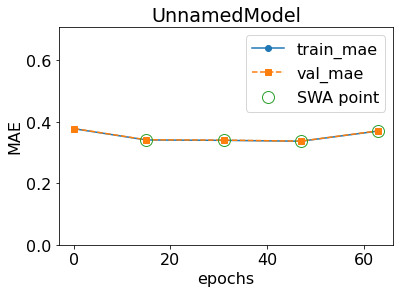

Epoch 79 failed to improve.
Discarded: 2/3 weight updates
Epoch: 79/304 --- train mae: 0.341 val mae: 0.342


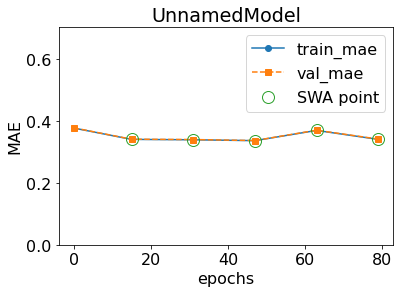

Epoch 95 failed to improve.
Discarded: 3/3 weight updates
Epoch: 95/304 --- train mae: 0.341 val mae: 0.342


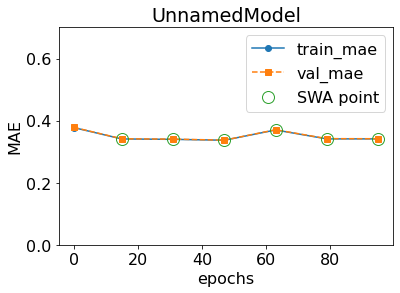

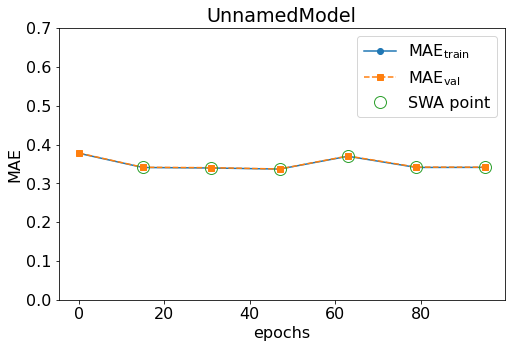

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 227410.97formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-26 12:04:02] ax.service.managed_loop: Running optimization trial 2...



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:1
Model size: 17863531 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 211445.60formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 96 (2**6.585)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 242005.32formulae/s]


loading data with up to 9 elements in the formula
stepping every 13664 training passes, cycling lr every 14 epochs
checkin at 28 epochs to match lr scheduler
300 epochs not divisible by 28 (2*epochs_step), updating epochs to 308 for learning
Epoch: 0/308 --- train mae: 0.355 val mae: 0.361


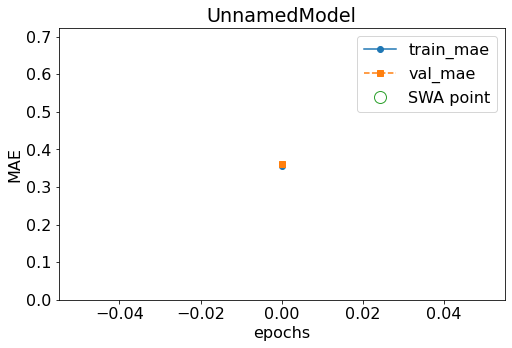

Epoch: 27/308 --- train mae: 0.192 val mae: 0.206


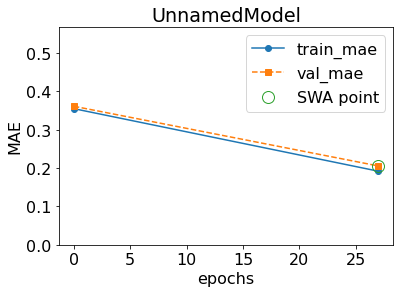

Epoch: 55/308 --- train mae: 0.174 val mae: 0.195


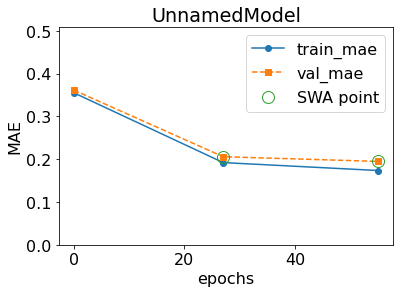

Epoch: 83/308 --- train mae: 0.159 val mae: 0.189


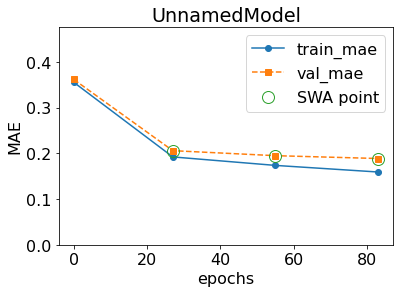

Epoch: 111/308 --- train mae: 0.144 val mae: 0.183


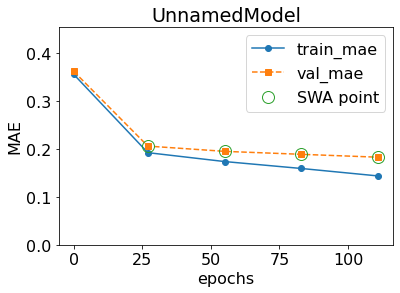

Epoch: 139/308 --- train mae: 0.128 val mae: 0.179


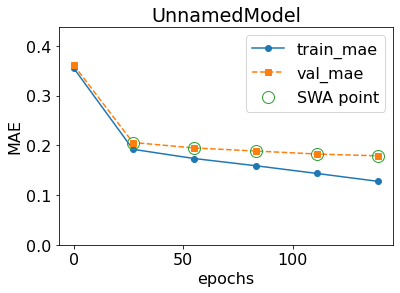

Epoch: 167/308 --- train mae: 0.111 val mae: 0.174


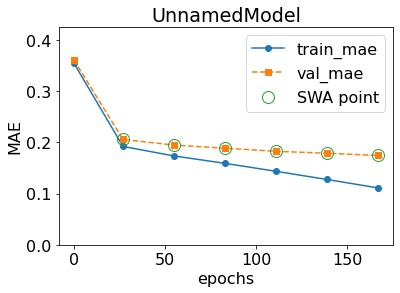

Epoch: 195/308 --- train mae: 0.0969 val mae: 0.173


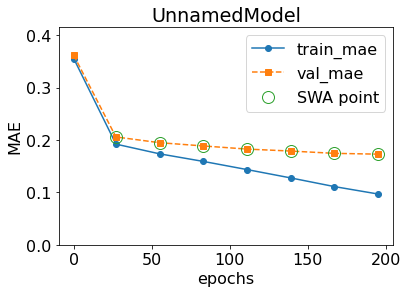

Epoch: 223/308 --- train mae: 0.0851 val mae: 0.171


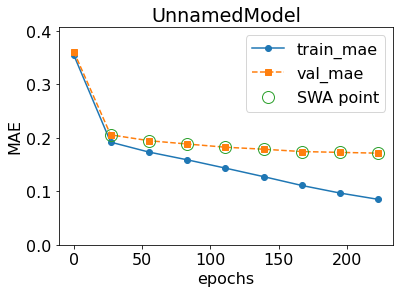

Epoch: 251/308 --- train mae: 0.0744 val mae: 0.171


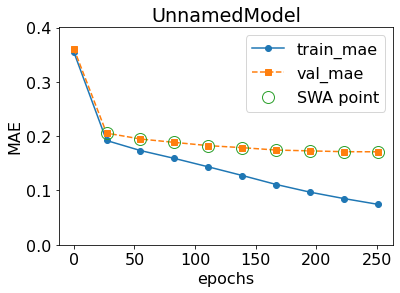

Epoch: 279/308 --- train mae: 0.0669 val mae: 0.17


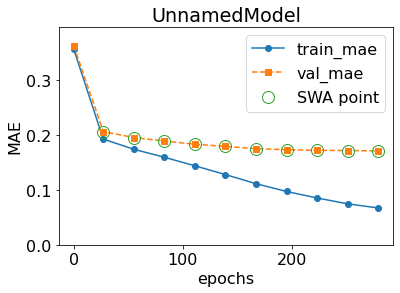

Epoch: 307/308 --- train mae: 0.0605 val mae: 0.171


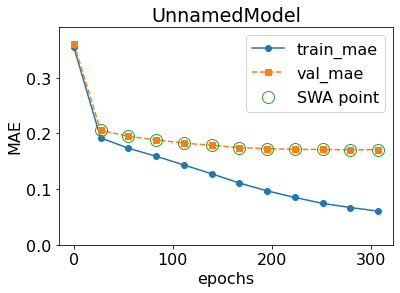

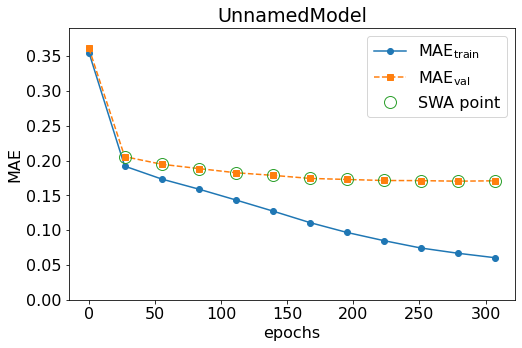

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 244519.35formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-26 23:38:41] ax.service.managed_loop: Running optimization trial 3...



Model architecture: out_dims, d_model, N, heads
3, 512, 1, 4
Running on compute device: cuda:1
Model size: 5185313 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 210497.79formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 41 (2**5.358)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 247010.49formulae/s]


loading data with up to 9 elements in the formula
stepping every 29692 training passes, cycling lr every 13 epochs
checkin at 26 epochs to match lr scheduler
300 epochs not divisible by 26 (2*epochs_step), updating epochs to 312 for learning
Epoch: 0/312 --- train mae: 0.341 val mae: 0.344


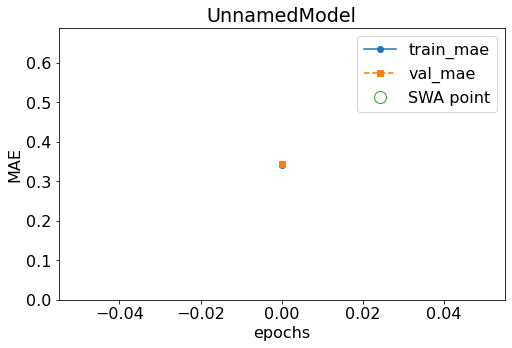

Epoch: 25/312 --- train mae: 0.227 val mae: 0.233


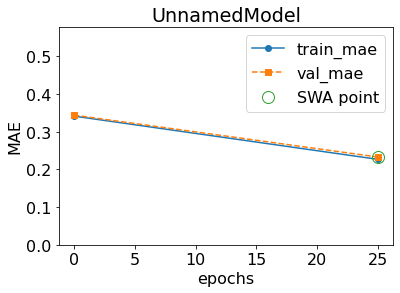

Epoch: 51/312 --- train mae: 0.224 val mae: 0.229


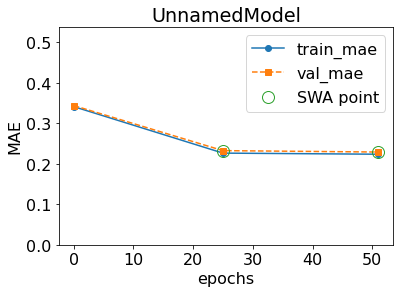

Epoch: 77/312 --- train mae: 0.22 val mae: 0.226


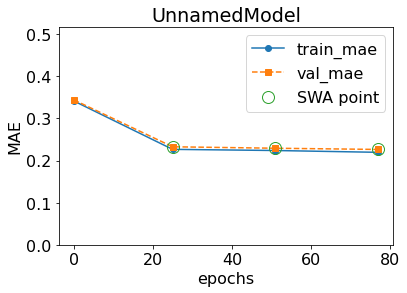

Epoch: 103/312 --- train mae: 0.217 val mae: 0.224


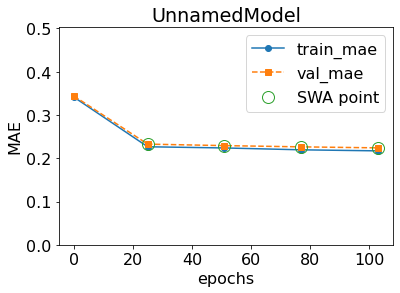

Epoch: 129/312 --- train mae: 0.218 val mae: 0.224


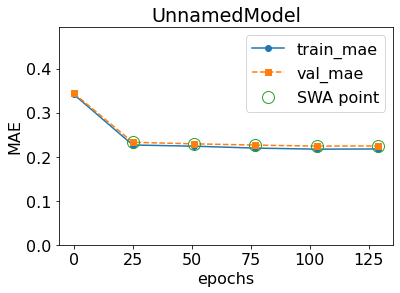

Epoch: 155/312 --- train mae: 0.218 val mae: 0.225


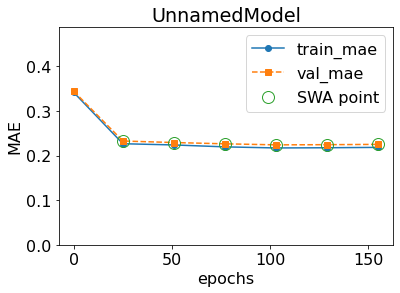

Epoch: 181/312 --- train mae: 0.218 val mae: 0.225


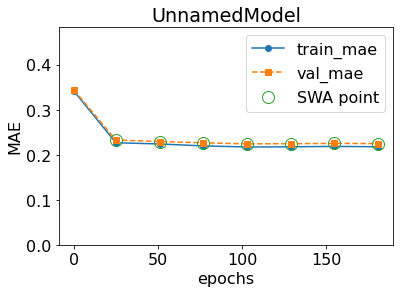

Epoch: 207/312 --- train mae: 0.219 val mae: 0.226


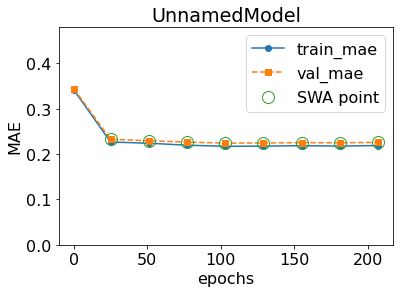

Epoch: 233/312 --- train mae: 0.216 val mae: 0.224


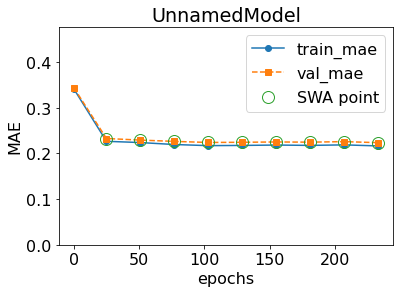

Epoch: 259/312 --- train mae: 0.218 val mae: 0.225


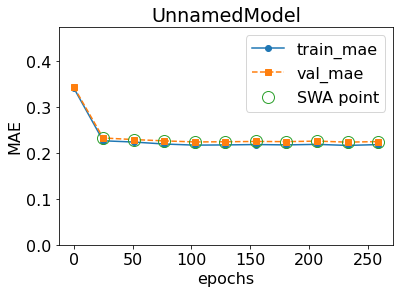

Epoch: 285/312 --- train mae: 0.217 val mae: 0.224


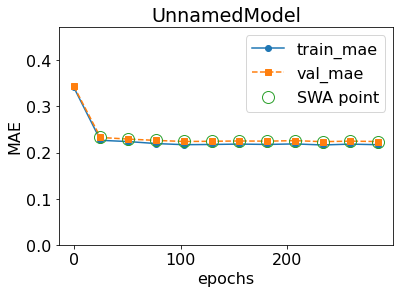

Epoch: 311/312 --- train mae: 0.217 val mae: 0.224


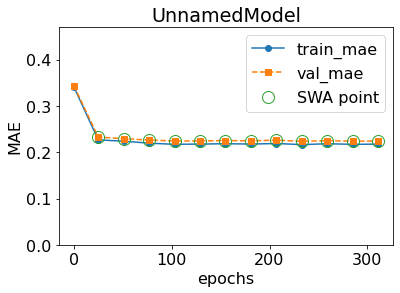

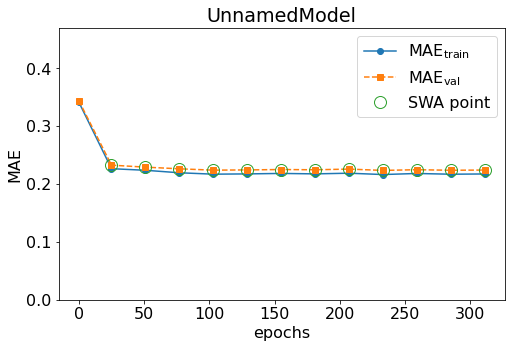

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 227458.16formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-28 03:07:50] ax.service.managed_loop: Running optimization trial 4...



Model architecture: out_dims, d_model, N, heads
3, 512, 5, 4
Running on compute device: cuda:1
Model size: 18240724 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 206374.11formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 98 (2**6.615)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 219447.00formulae/s]


loading data with up to 9 elements in the formula
stepping every 8604 training passes, cycling lr every 9 epochs
checkin at 18 epochs to match lr scheduler
300 epochs not divisible by 18 (2*epochs_step), updating epochs to 306 for learning
Epoch: 0/306 --- train mae: 0.355 val mae: 0.353


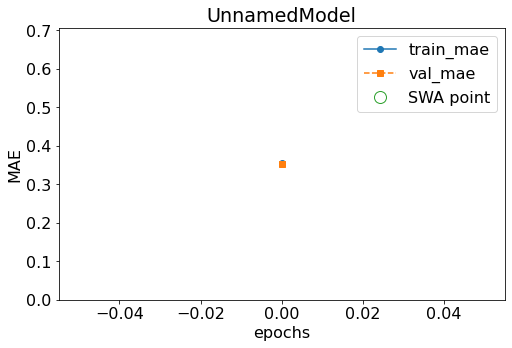

Epoch: 17/306 --- train mae: 0.233 val mae: 0.24


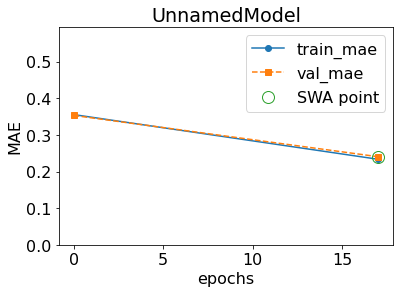

Epoch 35 failed to improve.
Discarded: 1/3 weight updates
Epoch: 35/306 --- train mae: 0.239 val mae: 0.246


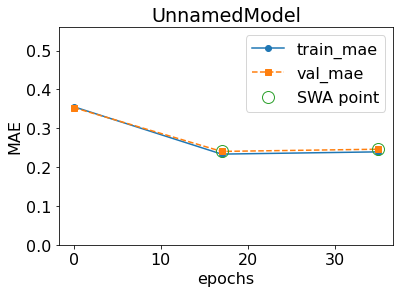

Epoch: 53/306 --- train mae: 0.23 val mae: 0.24


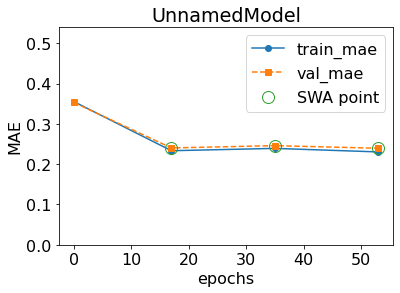

Epoch: 71/306 --- train mae: 0.227 val mae: 0.237


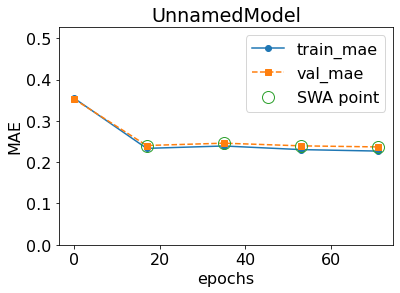

Epoch 89 failed to improve.
Discarded: 2/3 weight updates
Epoch: 89/306 --- train mae: 0.239 val mae: 0.247


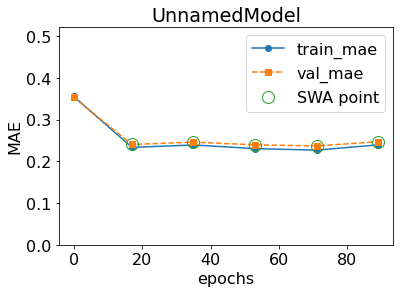

Epoch: 107/306 --- train mae: 0.228 val mae: 0.238


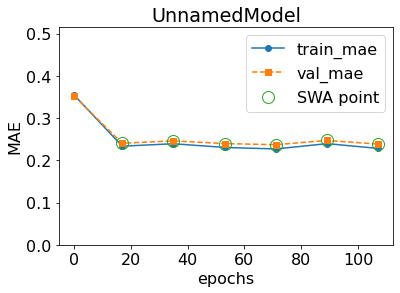

Epoch: 125/306 --- train mae: 0.227 val mae: 0.235


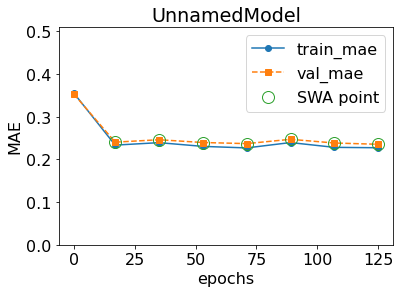

Epoch: 143/306 --- train mae: 0.222 val mae: 0.234


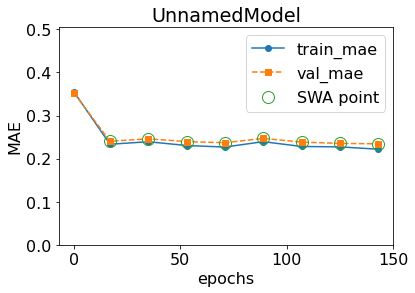

Epoch: 161/306 --- train mae: 0.226 val mae: 0.234


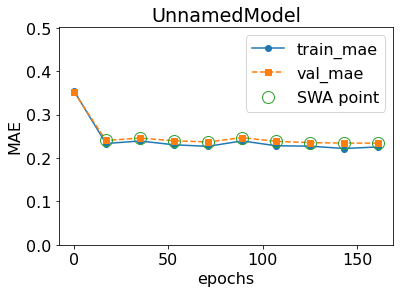

Epoch 179 failed to improve.
Discarded: 3/3 weight updates
Epoch: 179/306 --- train mae: 0.232 val mae: 0.239


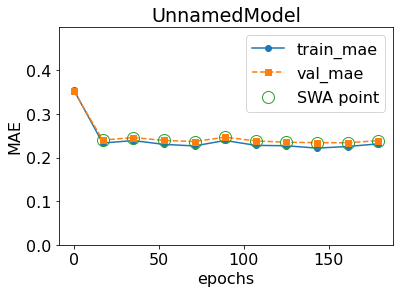

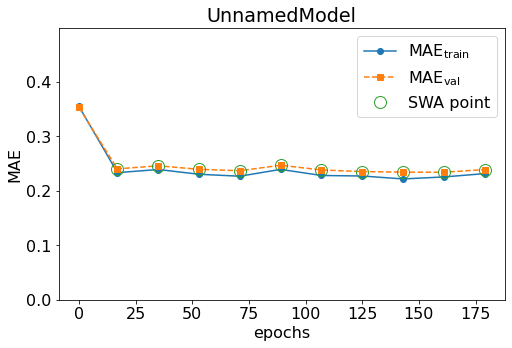

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 229237.26formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-28 13:36:53] ax.service.managed_loop: Running optimization trial 5...



Model architecture: out_dims, d_model, N, heads
3, 512, 4, 4
Running on compute device: cuda:1
Model size: 15422490 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 206815.51formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 116 (2**6.858)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 230210.65formulae/s]


loading data with up to 9 elements in the formula
stepping every 7272 training passes, cycling lr every 9 epochs
checkin at 18 epochs to match lr scheduler
300 epochs not divisible by 18 (2*epochs_step), updating epochs to 306 for learning
Epoch: 0/306 --- train mae: 0.322 val mae: 0.325


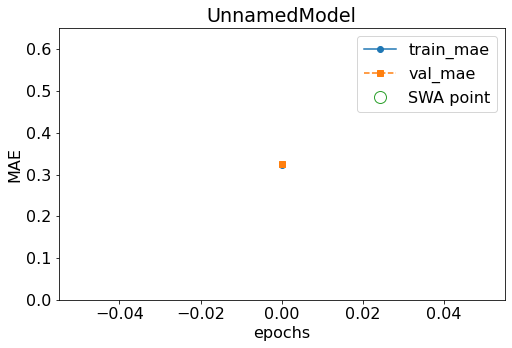

Epoch: 17/306 --- train mae: 0.202 val mae: 0.213


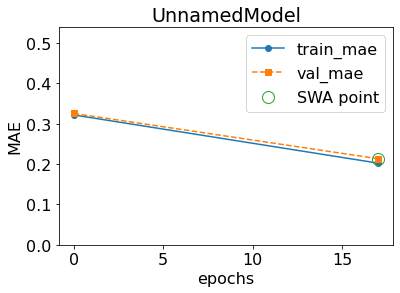

Epoch: 35/306 --- train mae: 0.197 val mae: 0.211


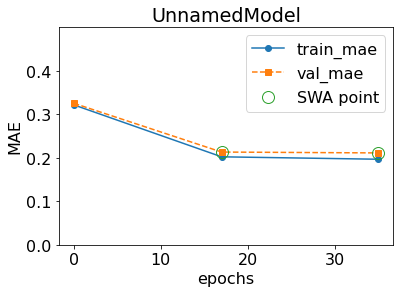

Epoch: 53/306 --- train mae: 0.199 val mae: 0.211


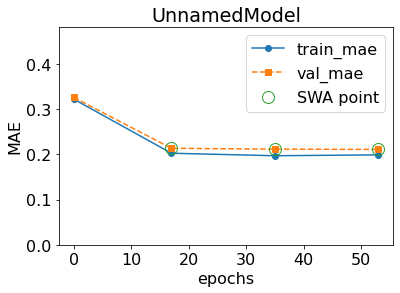

Epoch: 71/306 --- train mae: 0.196 val mae: 0.209


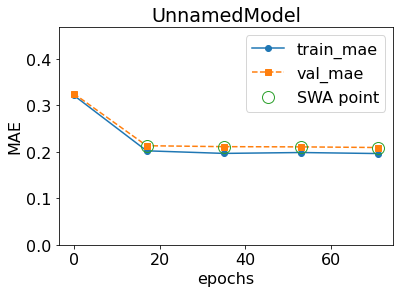

Epoch: 89/306 --- train mae: 0.198 val mae: 0.211


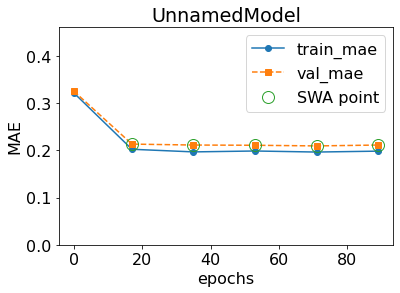

Epoch: 107/306 --- train mae: 0.196 val mae: 0.21


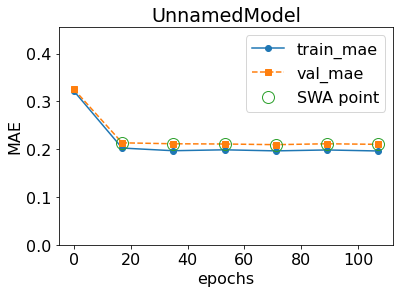

Epoch: 125/306 --- train mae: 0.196 val mae: 0.21


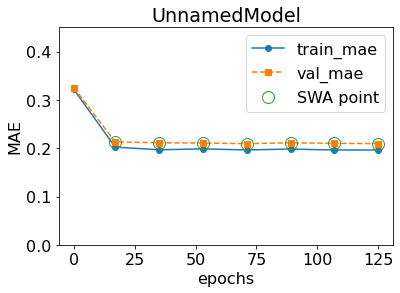

Epoch: 143/306 --- train mae: 0.196 val mae: 0.209


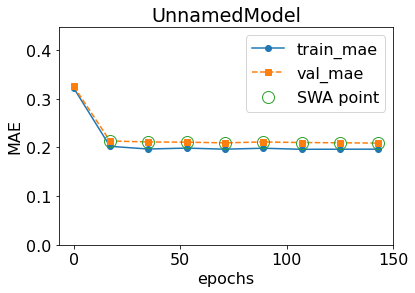

Epoch: 161/306 --- train mae: 0.197 val mae: 0.209


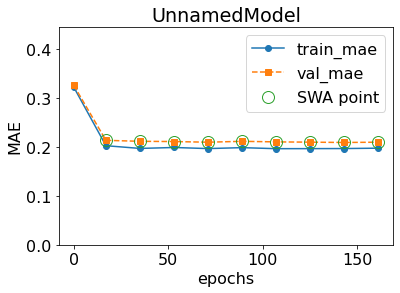

Epoch: 179/306 --- train mae: 0.198 val mae: 0.211


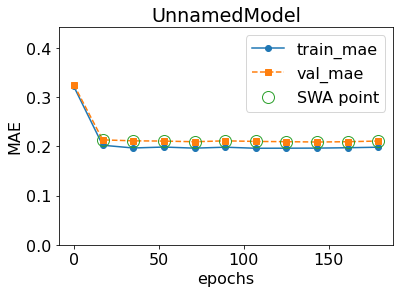

Epoch 197 failed to improve.
Discarded: 1/3 weight updates
Epoch: 197/306 --- train mae: 0.201 val mae: 0.212


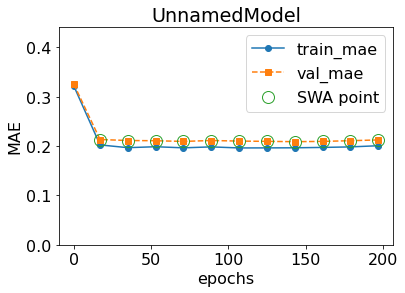

Epoch: 215/306 --- train mae: 0.198 val mae: 0.208


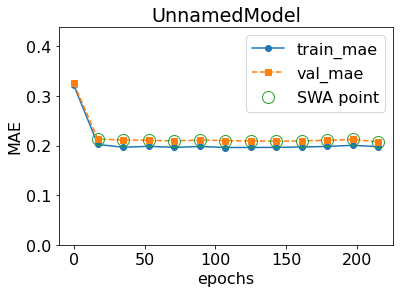

Epoch: 233/306 --- train mae: 0.199 val mae: 0.209


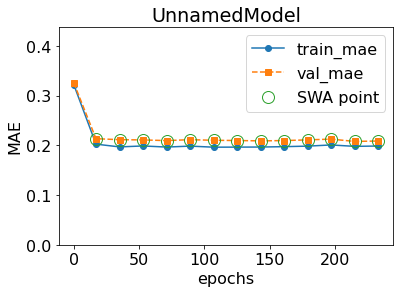

Epoch: 251/306 --- train mae: 0.198 val mae: 0.21


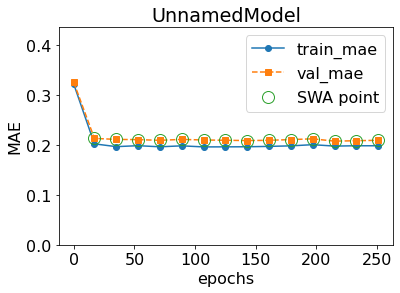

Epoch: 269/306 --- train mae: 0.2 val mae: 0.21


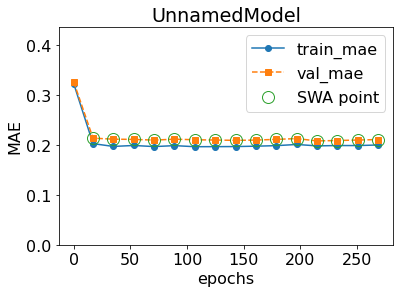

Epoch: 287/306 --- train mae: 0.198 val mae: 0.208


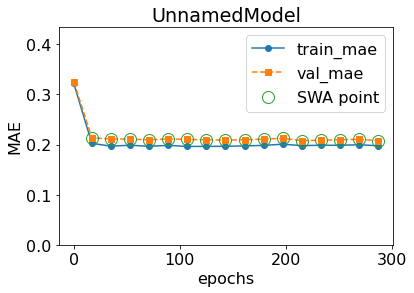

Epoch: 305/306 --- train mae: 0.196 val mae: 0.208


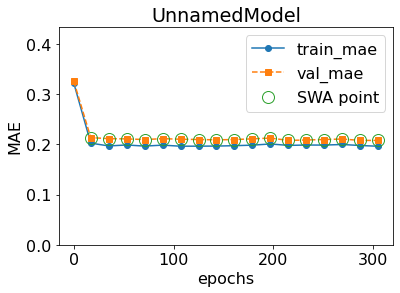

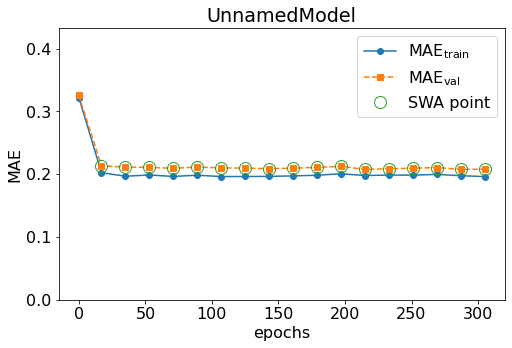

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 230397.78formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-29 02:04:16] ax.service.managed_loop: Running optimization trial 6...



Model architecture: out_dims, d_model, N, heads
3, 512, 7, 4
Running on compute device: cuda:1
Model size: 30889217 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 200629.11formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 212 (2**7.728)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 230143.75formulae/s]


loading data with up to 9 elements in the formula
stepping every 6188 training passes, cycling lr every 14 epochs
checkin at 28 epochs to match lr scheduler
300 epochs not divisible by 28 (2*epochs_step), updating epochs to 308 for learning
Epoch: 0/308 --- train mae: 0.343 val mae: 0.345


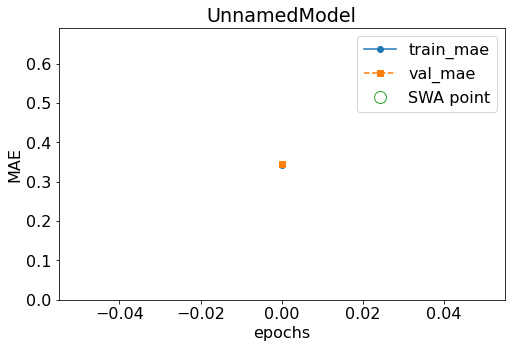

Epoch: 27/308 --- train mae: 0.192 val mae: 0.206


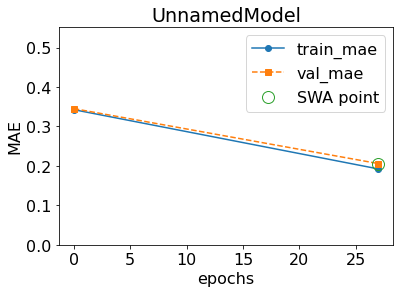

Epoch: 55/308 --- train mae: 0.166 val mae: 0.193


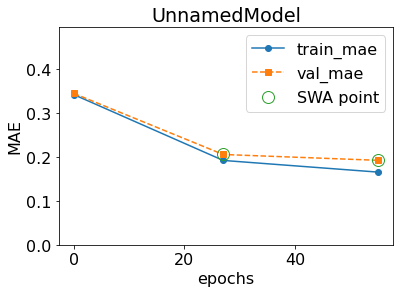

Epoch: 83/308 --- train mae: 0.149 val mae: 0.186


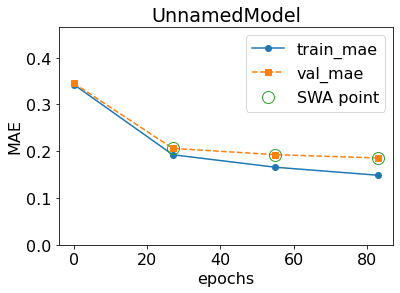

Epoch: 111/308 --- train mae: 0.136 val mae: 0.182


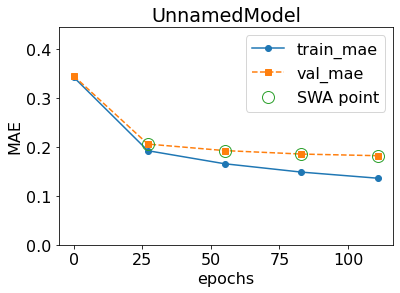

Epoch: 139/308 --- train mae: 0.122 val mae: 0.176


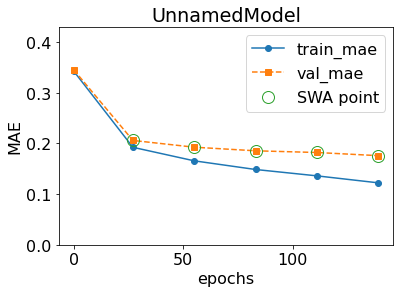

Epoch 167 failed to improve.
Discarded: 1/3 weight updates
Epoch: 167/308 --- train mae: 0.112 val mae: 0.179


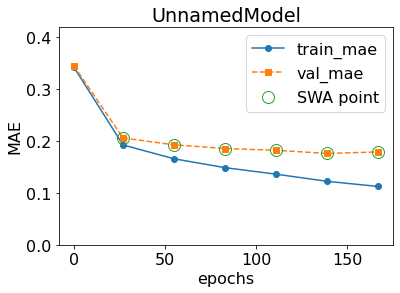

Epoch 195 failed to improve.
Discarded: 2/3 weight updates
Epoch: 195/308 --- train mae: 0.103 val mae: 0.179


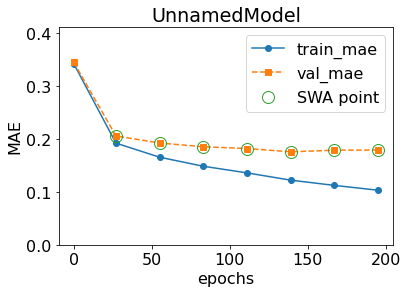

Epoch 223 failed to improve.
Discarded: 3/3 weight updates
Epoch: 223/308 --- train mae: 0.0961 val mae: 0.179


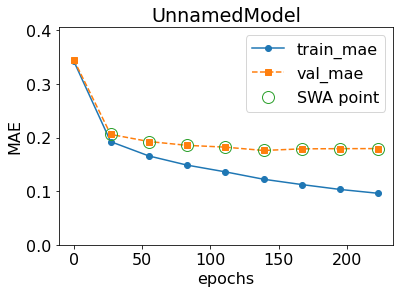

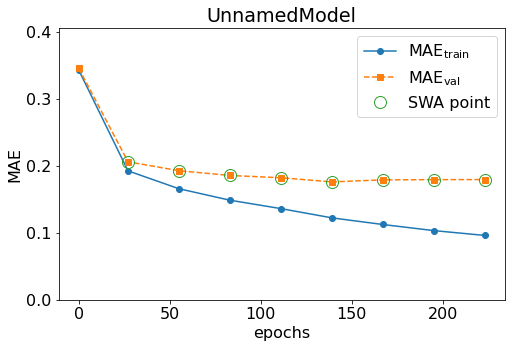

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 232872.77formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-29 08:17:38] ax.service.managed_loop: Running optimization trial 7...



Model architecture: out_dims, d_model, N, heads
3, 512, 6, 4
Running on compute device: cuda:1
Model size: 22791208 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 213232.45formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 93 (2**6.539)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 239478.12formulae/s]


loading data with up to 9 elements in the formula
stepping every 14098 training passes, cycling lr every 14 epochs
checkin at 28 epochs to match lr scheduler
300 epochs not divisible by 28 (2*epochs_step), updating epochs to 308 for learning
Epoch: 0/308 --- train mae: 0.374 val mae: 0.374


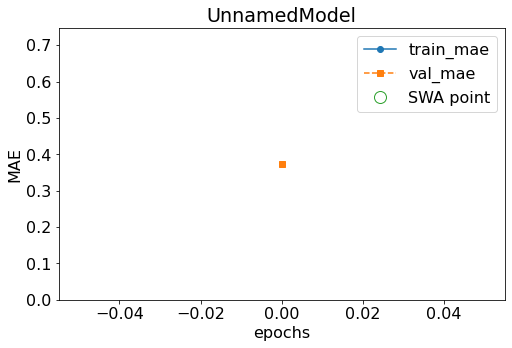

Epoch: 27/308 --- train mae: 0.202 val mae: 0.217


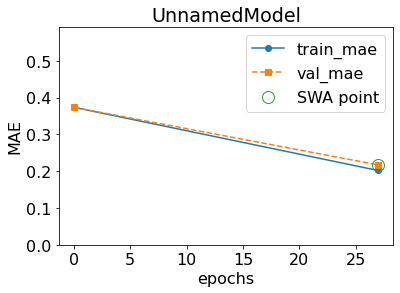

Epoch: 55/308 --- train mae: 0.197 val mae: 0.212


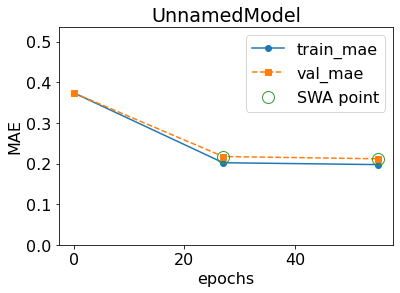

Epoch: 83/308 --- train mae: 0.2 val mae: 0.213


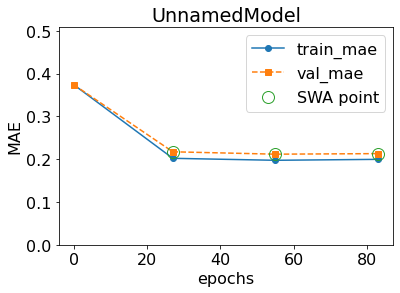

Epoch 111 failed to improve.
Discarded: 1/3 weight updates
Epoch: 111/308 --- train mae: 0.2 val mae: 0.214


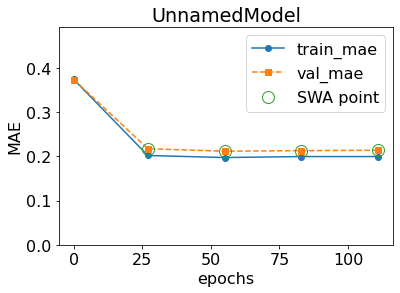

Epoch 139 failed to improve.
Discarded: 2/3 weight updates
Epoch: 139/308 --- train mae: 0.198 val mae: 0.214


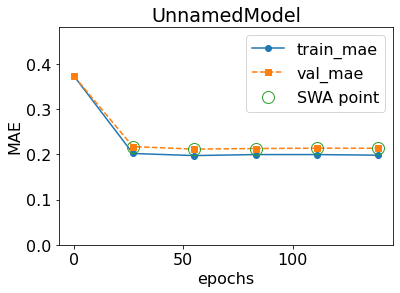

Epoch 167 failed to improve.
Discarded: 3/3 weight updates
Epoch: 167/308 --- train mae: 0.203 val mae: 0.217


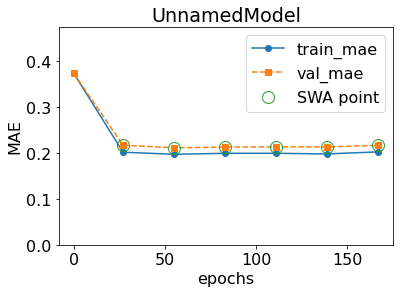

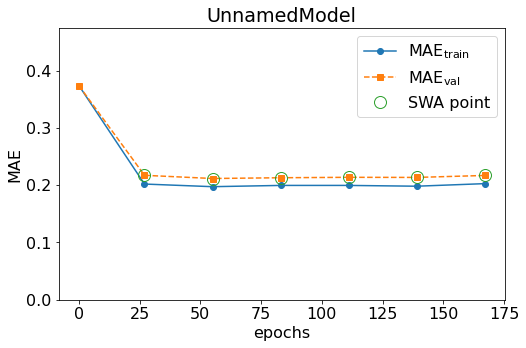

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 163012.36formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-29 17:50:19] ax.service.managed_loop: Running optimization trial 8...



Model architecture: out_dims, d_model, N, heads
3, 512, 4, 4
Running on compute device: cuda:1
Model size: 17587290 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 127926.19formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 184 (2**7.524)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 227896.18formulae/s]


loading data with up to 9 elements in the formula
stepping every 6108 training passes, cycling lr every 12 epochs
checkin at 24 epochs to match lr scheduler
300 epochs not divisible by 24 (2*epochs_step), updating epochs to 312 for learning
Epoch: 0/312 --- train mae: 0.349 val mae: 0.343


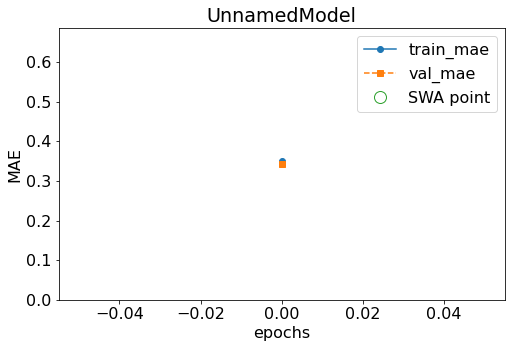

Epoch: 23/312 --- train mae: 0.194 val mae: 0.206


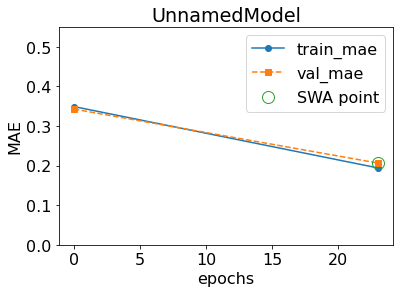

Epoch: 47/312 --- train mae: 0.177 val mae: 0.196


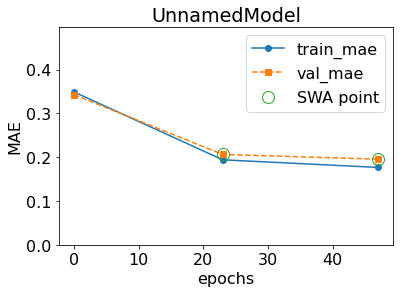

Epoch: 71/312 --- train mae: 0.164 val mae: 0.189


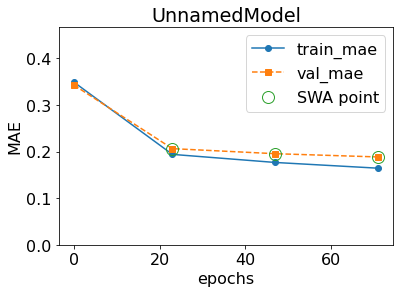

Epoch: 95/312 --- train mae: 0.153 val mae: 0.183


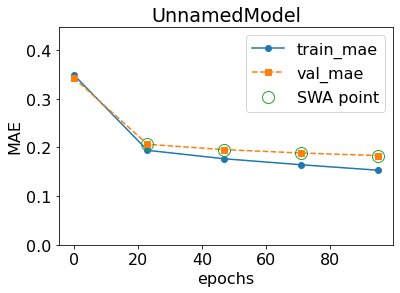

Epoch: 119/312 --- train mae: 0.143 val mae: 0.18


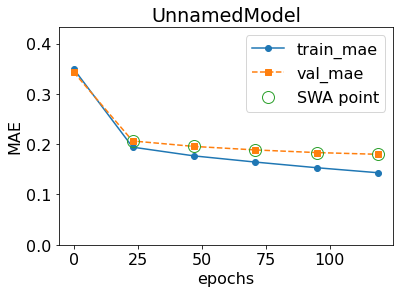

Epoch: 143/312 --- train mae: 0.133 val mae: 0.177


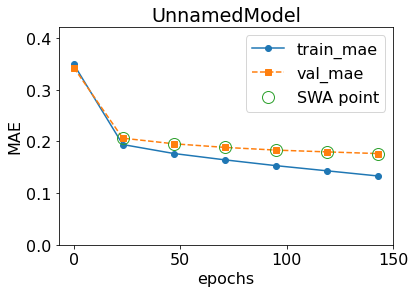

Epoch: 167/312 --- train mae: 0.124 val mae: 0.176


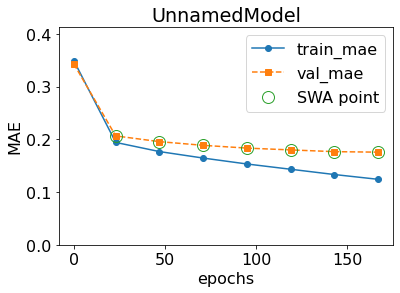

Epoch: 191/312 --- train mae: 0.114 val mae: 0.175


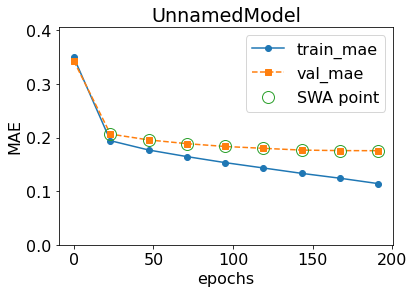

Epoch: 215/312 --- train mae: 0.106 val mae: 0.175


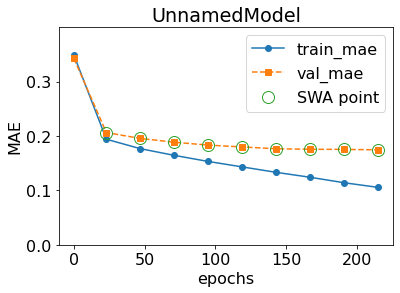

Epoch: 239/312 --- train mae: 0.0982 val mae: 0.176


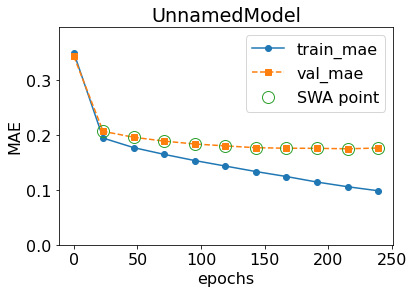

Epoch: 263/312 --- train mae: 0.0902 val mae: 0.176


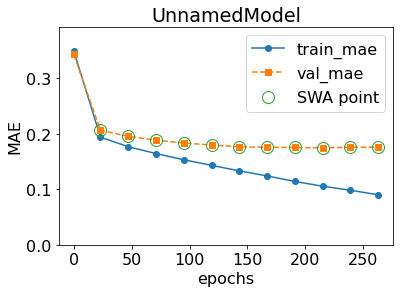

Epoch: 287/312 --- train mae: 0.0837 val mae: 0.176


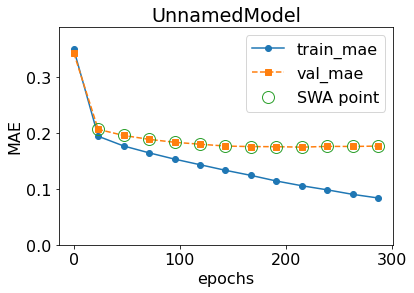

Epoch: 311/312 --- train mae: 0.0769 val mae: 0.175


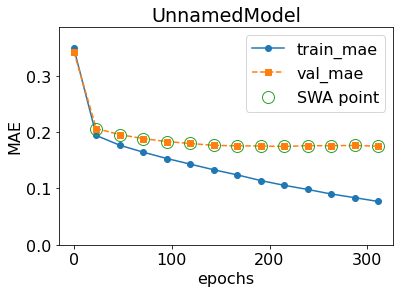

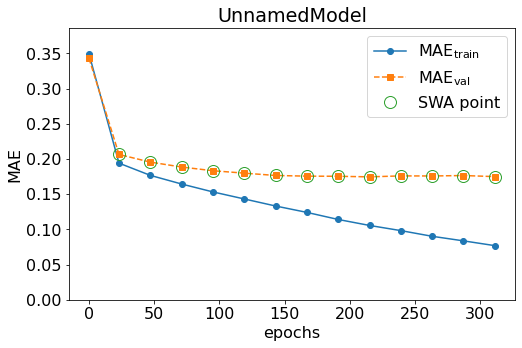

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 227911.77formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-30 01:33:19] ax.service.managed_loop: Running optimization trial 9...



Model architecture: out_dims, d_model, N, heads
3, 512, 9, 4
Running on compute device: cuda:1
Model size: 49379185 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:00<00:00, 198089.57formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 180 (2**7.492)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 239469.36formulae/s]


loading data with up to 9 elements in the formula
stepping every 6252 training passes, cycling lr every 12 epochs
checkin at 24 epochs to match lr scheduler
300 epochs not divisible by 24 (2*epochs_step), updating epochs to 312 for learning
Epoch: 0/312 --- train mae: 0.428 val mae: 0.427


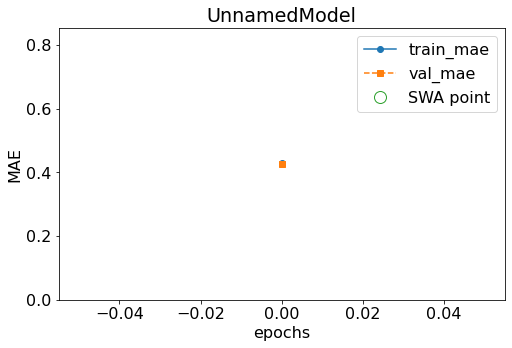

Epoch: 23/312 --- train mae: 0.442 val mae: 0.441


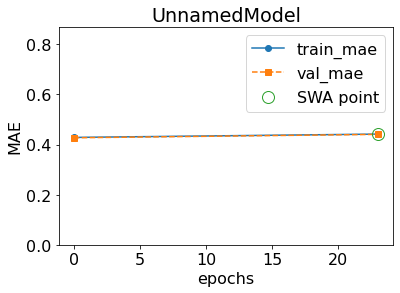

Epoch: 47/312 --- train mae: 0.437 val mae: 0.436


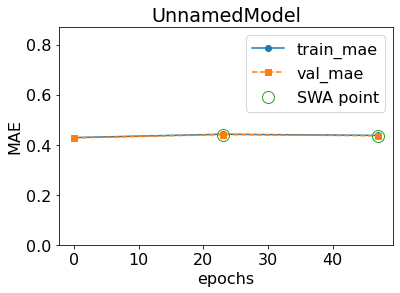

Epoch: 71/312 --- train mae: 0.437 val mae: 0.436


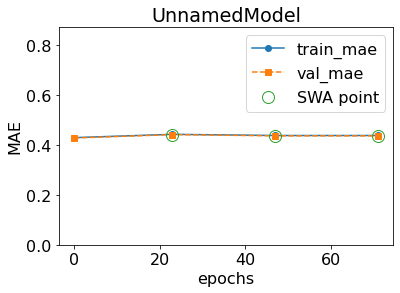

Epoch: 95/312 --- train mae: 0.436 val mae: 0.435


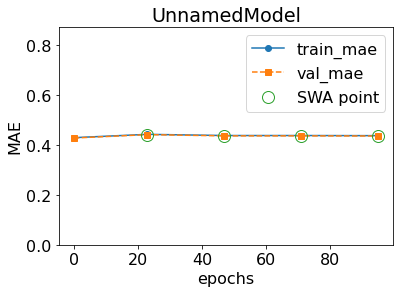

Epoch: 119/312 --- train mae: 0.434 val mae: 0.433


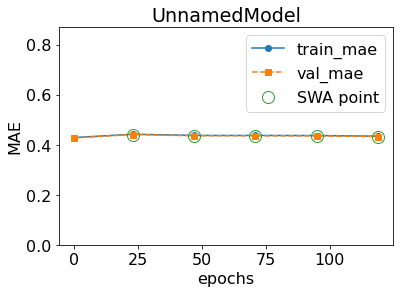

Epoch: 143/312 --- train mae: 0.433 val mae: 0.432


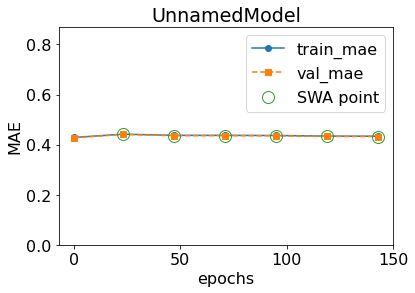

Epoch: 167/312 --- train mae: 0.436 val mae: 0.435


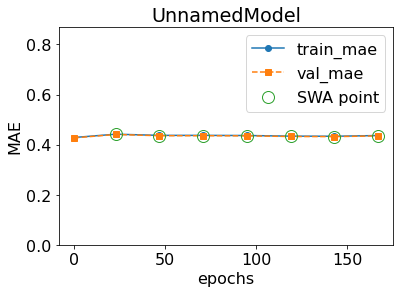

Epoch: 191/312 --- train mae: 0.436 val mae: 0.435


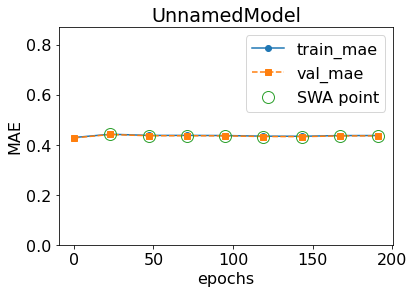

Epoch: 215/312 --- train mae: 0.436 val mae: 0.435


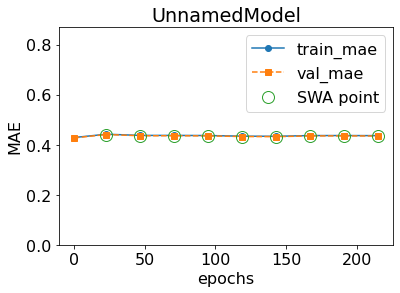

Epoch: 239/312 --- train mae: 0.435 val mae: 0.433


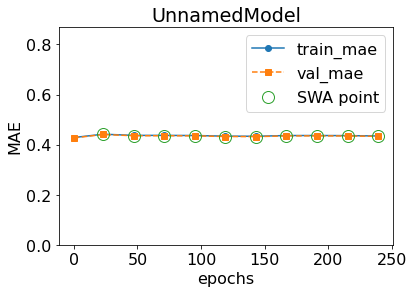

Epoch: 263/312 --- train mae: 0.435 val mae: 0.434


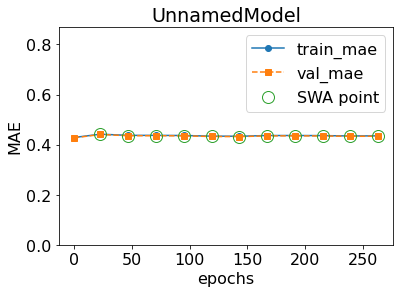

Epoch: 287/312 --- train mae: 0.437 val mae: 0.436


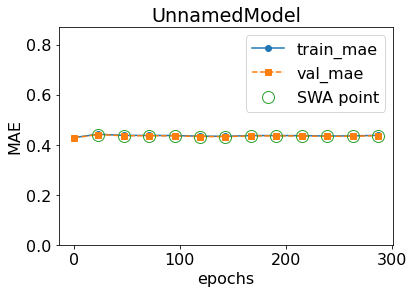

Epoch: 311/312 --- train mae: 0.436 val mae: 0.435


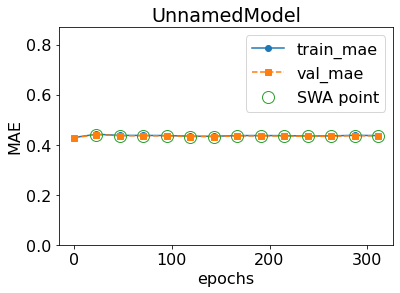

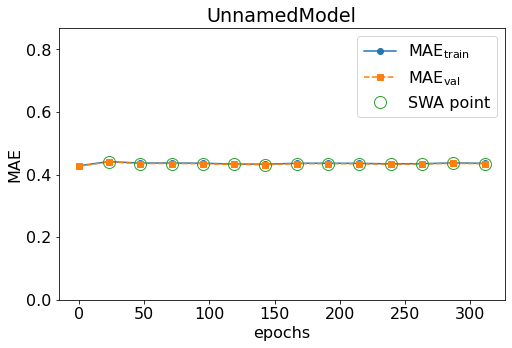

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 66838.77formulae/s]


loading data with up to 9 elements in the formula


[INFO 09-30 16:15:29] ax.service.managed_loop: Running optimization trial 10...



Model architecture: out_dims, d_model, N, heads
3, 512, 4, 4
Running on compute device: cuda:1
Model size: 12708290 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:01<00:00, 61935.52formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 176 (2**7.459)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 89940.84formulae/s]


loading data with up to 9 elements in the formula
stepping every 4264 training passes, cycling lr every 8 epochs
checkin at 16 epochs to match lr scheduler
300 epochs not divisible by 16 (2*epochs_step), updating epochs to 304 for learning
Epoch: 0/304 --- train mae: 0.395 val mae: 0.398


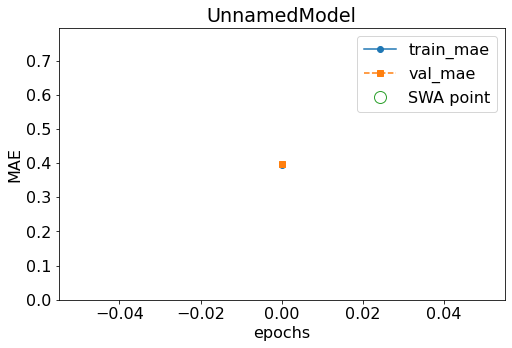

Epoch: 15/304 --- train mae: 0.235 val mae: 0.237


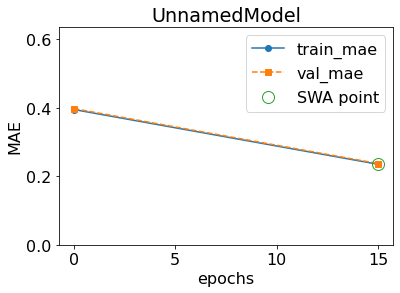

Epoch: 31/304 --- train mae: 0.22 val mae: 0.224


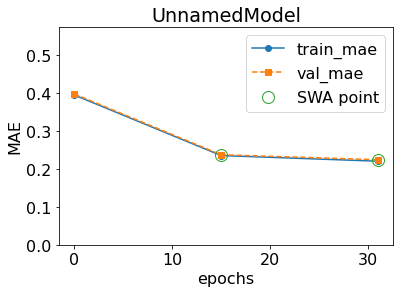

Epoch: 47/304 --- train mae: 0.211 val mae: 0.215


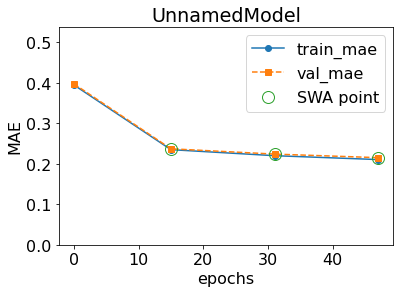

Epoch: 63/304 --- train mae: 0.203 val mae: 0.209


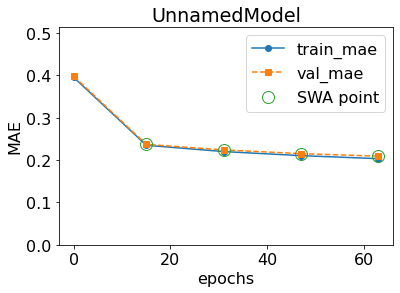

Epoch: 79/304 --- train mae: 0.197 val mae: 0.204


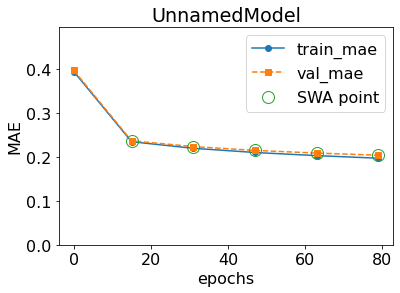

Epoch: 95/304 --- train mae: 0.192 val mae: 0.201


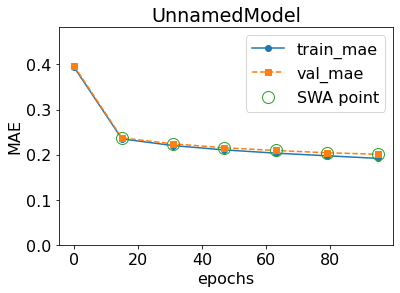

Epoch: 111/304 --- train mae: 0.187 val mae: 0.199


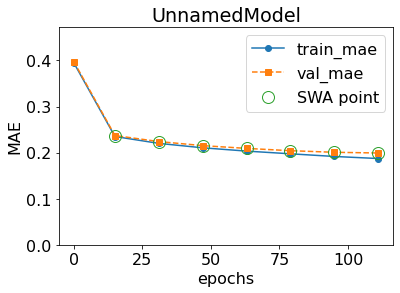

Epoch: 127/304 --- train mae: 0.183 val mae: 0.197


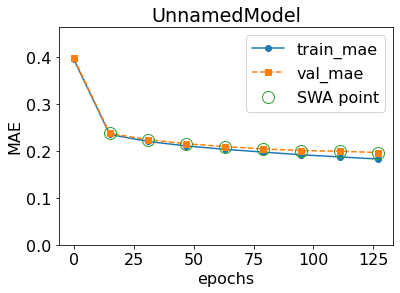

Epoch: 143/304 --- train mae: 0.178 val mae: 0.195


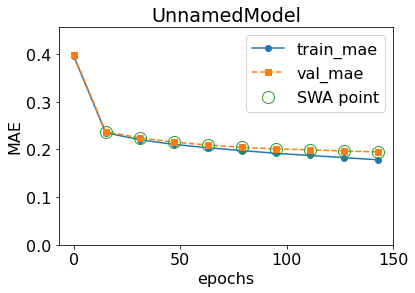

Epoch: 159/304 --- train mae: 0.174 val mae: 0.193


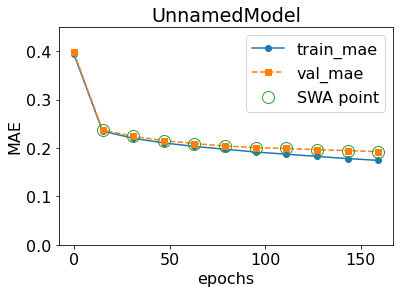

Epoch: 175/304 --- train mae: 0.171 val mae: 0.19


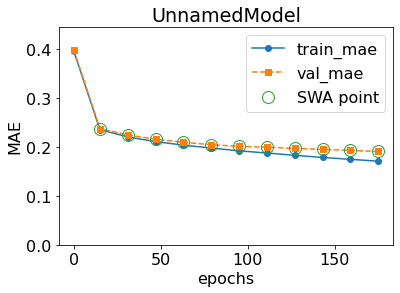

Epoch: 191/304 --- train mae: 0.168 val mae: 0.19


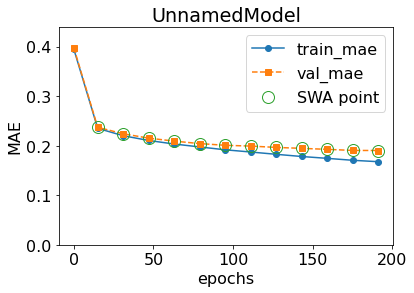

Epoch: 207/304 --- train mae: 0.164 val mae: 0.188


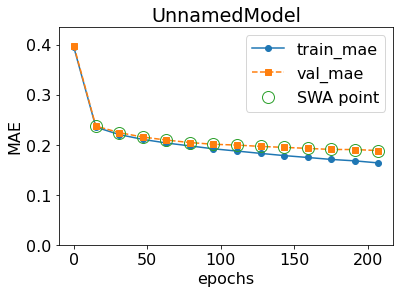

Epoch: 223/304 --- train mae: 0.161 val mae: 0.187


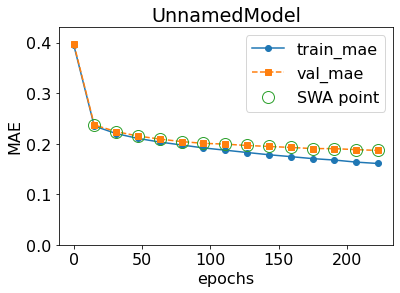

Epoch: 239/304 --- train mae: 0.157 val mae: 0.187


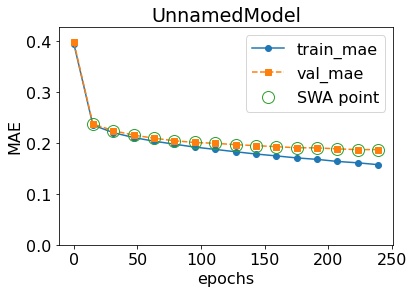

Epoch: 255/304 --- train mae: 0.154 val mae: 0.185


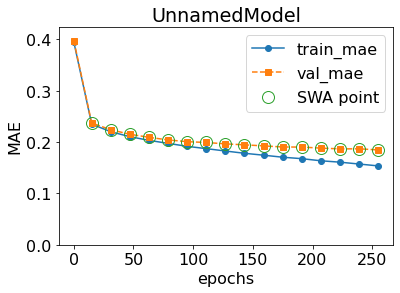

Epoch: 271/304 --- train mae: 0.15 val mae: 0.185


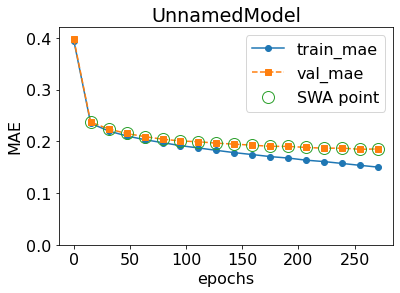

Epoch: 287/304 --- train mae: 0.147 val mae: 0.184


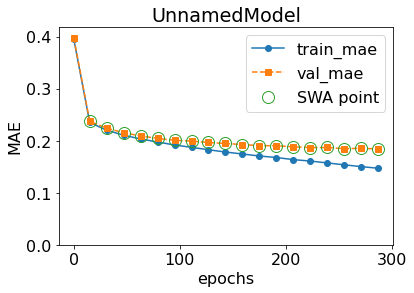

Epoch: 303/304 --- train mae: 0.144 val mae: 0.184


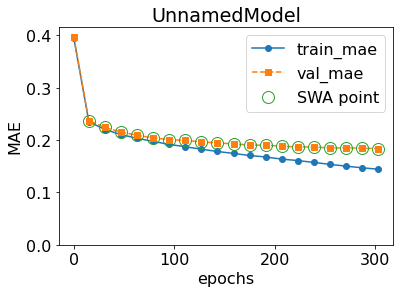

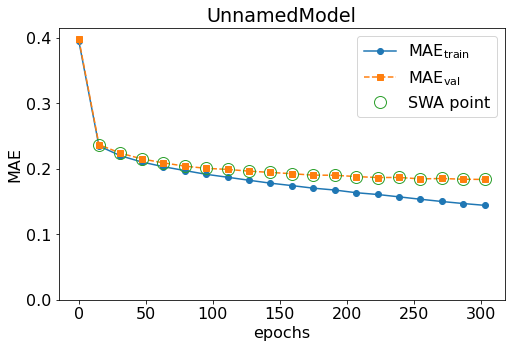

Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 115977.05formulae/s]


loading data with up to 9 elements in the formula
{'batch_size': 96, 'fudge': 0.010467939544469118, 'N': 3, 'emb_scaler': 0.3760431054979563, 'bias': False, 'dim_feedforward': 3959, 'dropout': 0.13284094538539648, 'epochs_step': 14, 'pe_resolution': 5593, 'ple_resolution': 7542, 'lr': 0.005926845657546073, 'eps': 4.053645860757679e-05, 'weight_decay': 0.135106997564435, 'alpha': 0.05793841276317835, 'k': 3, 'elem_prop': 'magpie', 'criterion': 'RobustL1'}
({'mae': 0.17471767123228477}, {'mae': {'mae': nan}})


In [25]:
best_parameters, best_values, experiment, model = optimize(
        parameters=[
          {"name": "batch_size", "type": "range", "bounds": [32, 256]},
          {"name": "fudge", "type": "range", "bounds": [0.0, 0.1]},
          # {"name": "d_model", "type": "range", "bounds": [100, 1024]},
          {"name": "N", "type": "range", "bounds": [1, 10]},
          # {"name": "heads", "type": "range", "bounds": [1, 10]},
          # {"name": "out_hidden4", "type": "range", "bounds": [32, 512]},
          {"name": "emb_scaler", "type": "range", "bounds": [0.0, 1.0]},
          # {"name": "pos_scaler", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "bias", "type": "choice", "values": [False, True]},
          {"name": "dim_feedforward", "type": "range", "bounds": [1024, 4096],},
          {"name": "dropout", "type": "range", "bounds": [0.0, 1.0]},
          {
            "name": "elem_prop",
            "type": "choice",
            "values": ["mat2vec",
                    "oliynyk",
                    "magpie",
                    "onehot",],
          },
          {"name": "epochs_step", "type": "range", "bounds": [5, 20]},
          {"name": "pe_resolution", "type": "range", "bounds": [2500, 10000]},
          {"name": "ple_resolution", "type": "range", "bounds": [2500, 10000],},
          {
            "name": "criterion",
            "type": "choice",
            "values": ["RobustL1", "RobustL2"],
          },
          {"name": "lr", "type": "range", "bounds": [0.0001, 0.006]},
          # {"name": "betas1", "type": "range", "bounds": [0.5, 0.9999]},
          # {"name": "betas2", "type": "range", "bounds": [0.5, 0.9999]},
          {"name": "eps", "type": "range", "bounds": [0.0000001, 0.0001]},
          {"name": "weight_decay", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "alpha", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "k", "type": "range", "bounds": [2, 10]},
        ],
        experiment_name="crabnet-hyperparameter_tuning",
        evaluation_function=crabnet_evaluation,
        objective_name="mae",
        minimize=True,
        # parameter_constraints=["betas1 <= betas2", "emb_scaler + pos_scaler <= 1"],
        total_trials= 10)

print(best_parameters)
print(best_values)

# default_model= CrabNet(force_cpu=False, epochs=300)
# default_model.fit(df_train)
# default_y_predicted= default_model.predict(df_test)
# default_mae = mean_absolute_error(df_test['target'].to_list(), default_y_predicted)

# del default_model
# gc.collect()
# torch.cuda.empty_cache()

# best_parameterization = correct_parameterization(best_parameters)
# test_model = CrabNet(**best_parameterization, force_cpu=False, epochs=300)
# test_model.fit(df_train)
# test_y_predicted= test_model.predict(df_test)
# test_mae = mean_absolute_error(df_test['target'].to_list(), test_y_predicted)

# del test_model
# gc.collect()
# torch.cuda.empty_cache()

##Training CrabNet for stability prediction


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda
Model size: 17863531 parameters



Generating EDM: 100%|██████████| 93644/93644 [00:01<00:00, 58594.50formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 96 (2**6.585)


Generating EDM: 100%|██████████| 23412/23412 [00:00<00:00, 85052.96formulae/s]


loading data with up to 9 elements in the formula
stepping every 13664 training passes, cycling lr every 14 epochs
checkin at 28 epochs to match lr scheduler
500 epochs not divisible by 28 (2*epochs_step), updating epochs to 504 for learning
Epoch: 0/504 --- train mae: 0.356 val mae: 0.354


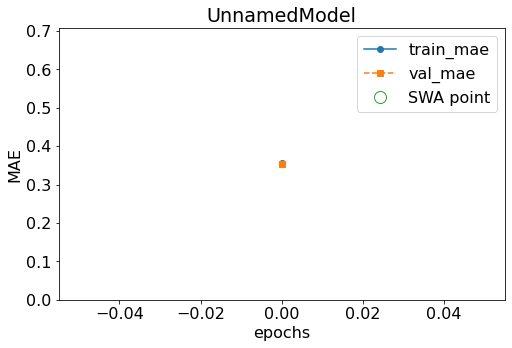

Epoch: 27/504 --- train mae: 0.189 val mae: 0.203


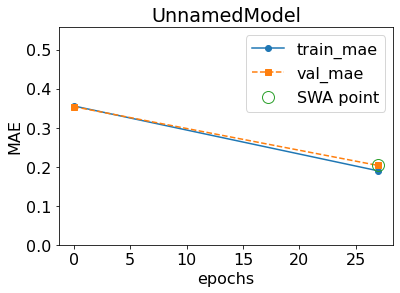

Epoch: 55/504 --- train mae: 0.171 val mae: 0.192


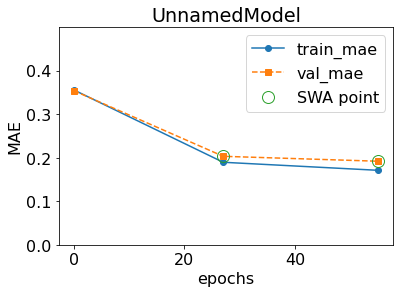

Epoch: 83/504 --- train mae: 0.157 val mae: 0.186


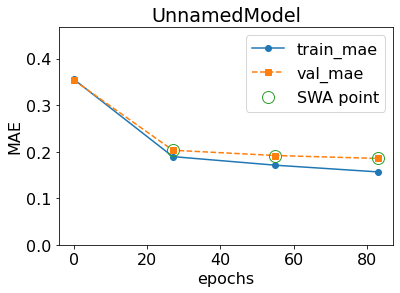

Epoch: 111/504 --- train mae: 0.141 val mae: 0.179


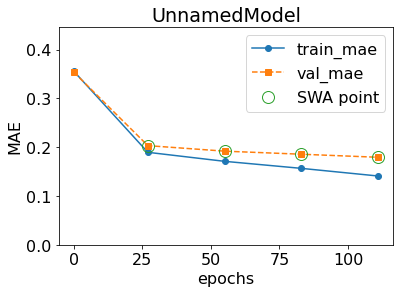

Epoch: 139/504 --- train mae: 0.126 val mae: 0.175


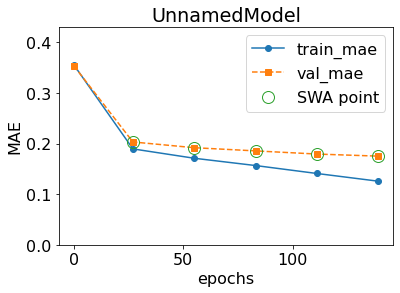

Epoch: 167/504 --- train mae: 0.11 val mae: 0.172


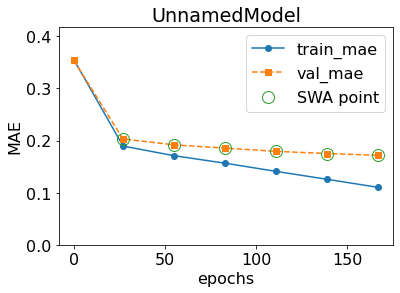

Epoch: 195/504 --- train mae: 0.0961 val mae: 0.169


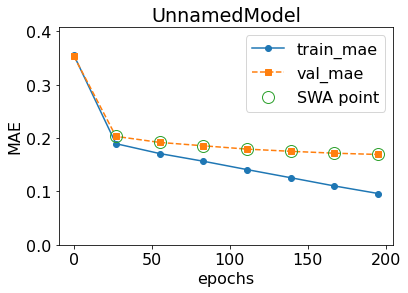

Epoch: 223/504 --- train mae: 0.0846 val mae: 0.169


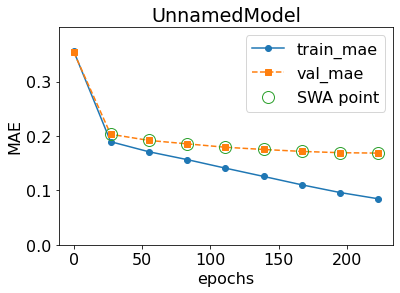

Epoch: 251/504 --- train mae: 0.0746 val mae: 0.169


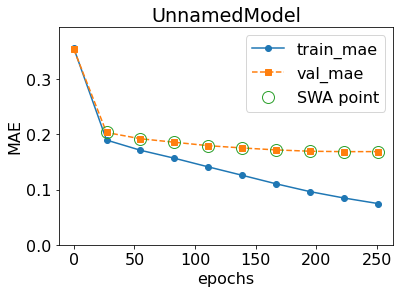

Epoch: 279/504 --- train mae: 0.0667 val mae: 0.168


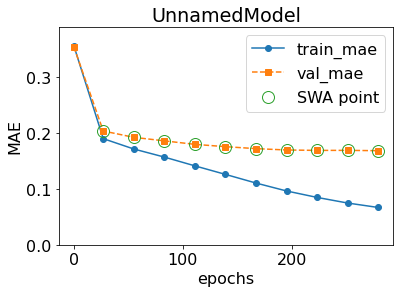

Epoch 307 failed to improve.
Discarded: 1/3 weight updates
Epoch: 307/504 --- train mae: 0.0607 val mae: 0.17


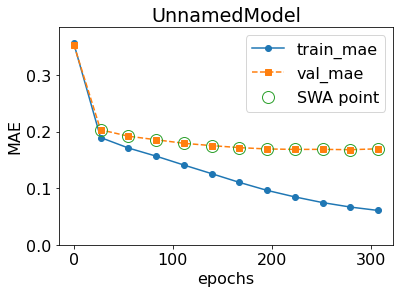

Epoch: 335/504 --- train mae: 0.0564 val mae: 0.168


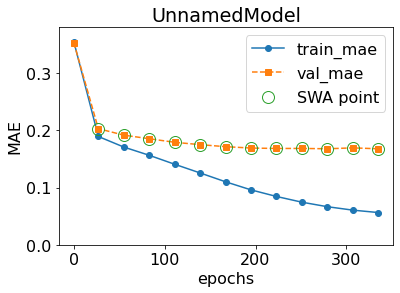

Epoch 363 failed to improve.
Discarded: 2/3 weight updates
Epoch: 363/504 --- train mae: 0.0527 val mae: 0.169


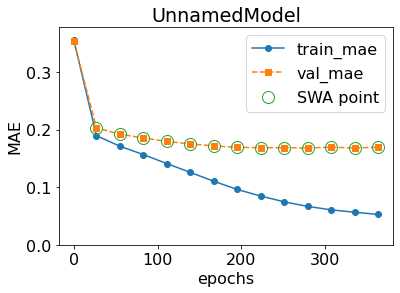

Epoch 391 failed to improve.
Discarded: 3/3 weight updates
Epoch: 391/504 --- train mae: 0.0503 val mae: 0.169


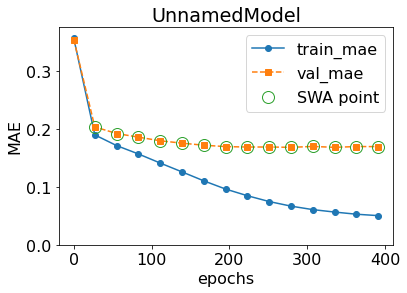

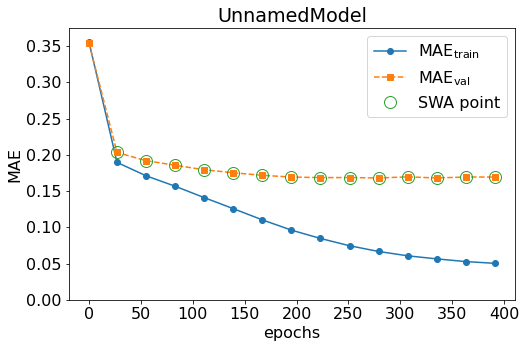

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models\trained_models\UnnamedModel.pth


Generating EDM: 100%|██████████| 29264/29264 [00:00<00:00, 69696.47formulae/s]


loading data with up to 9 elements in the formula


In [26]:
# best_parameterization = correct_parameterization(best_parameters)
cb_st = CrabNet(mat_prop="stability", compute_device="cuda", classification=True, **best_parameters, epochs = 500)
cb_st.fit(df_train_st)
val_pred_st, val_sigma_st = cb_e.predict(df_test_st, return_uncertainty=True)

# cb_st = CrabNet(mat_prop="stability", classification=True, compute_device="cuda", epochs = 10000)
# cb_st.fit(train_df_st)
# val_pred_st, val_sigma_st = cb_st.predict(val_df_st, return_uncertainty=True)

##Predicting stability

In [27]:
test_df_st = test_df_e
test_pred_st, test_sigma_st = cb_st.predict(test_df_st, return_uncertainty=True)

test_df_st["predicted_stability"] = test_pred_st
test_df_st["uncertainty_for_stability"] = test_sigma_st
#print(test_df_st)

test_df_st.to_csv("final.csv")
!cp final.csv "C:/Users/Hasan Sayeed/Documents/hasan/DISCOVER"      #"/content/drive/MyDrive/"

Generating EDM: 100%|██████████| 100000/100000 [00:01<00:00, 71722.00formulae/s]


loading data with up to 9 elements in the formula


'cp' is not recognized as an internal or external command,
operable program or batch file.
